# Proyecto de Visión Artificial y Reconocimiento de Patrones

## Reconocimiento Visual de Videojuegos
* Pablo
* Alberto Pérez Álvarez

## 1. Introducción

En esta práctica aplicaremos **Deep Learning** para clasificar imágenes satelitales del conjunto de datos **EuroSAT**. El objetivo es identificar el uso del suelo (bosques, zonas industriales, cultivos, etc.) utilizando tanto redes diseñadas desde cero como técnicas de Transfer Learning.

### Instrucciones de Dataset (Kaggle)
Para que esta libreta funcione, debes añadir el siguiente dataset a tu entorno (en principio, si clonais la libreta lo deberíais de tener por defecto):
1.  En el menú derecho, pulsa **Add Input**.
2.  Busca **"EuroSAT Dataset"** (del usuario *Gota Dahiya*).
3.  Añádelo pulsando el botón `+`.

### Configuración Inicial
Asegúrate de tener activada la **GPU** (T4 x2 o P100) para acelerar el entrenamiento.

In [16]:
#!pip install "protobuf==3.20.3" > /dev/null 2>&1  #Si no, da un error de compatibilidad entre liberías.
import os

# Configuración de entorno
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetV2B0
from transformers import TFViTModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import PIL.Image
import time
from sklearn.metrics import classification_report, confusion_matrix
import gc 

In [17]:
# Reproducibilidad
SEED = 2025
tf.random.set_seed(SEED)
np.random.seed(SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: True


---

## 2. Carga y Gestión de Datos

Utilizaremos `tf.keras.utils.image_dataset_from_directory`. Esta función crea un generador de datos que carga las imágenes del disco bajo demanda, evitando saturar la memoria RAM.

In [18]:
KAGGLE_PATH = '/kaggle/input/videojuegos/images_dataset'
# Ruta que tendria en local.
LOCAL_PATH = './images_dataset' 

# Kaggle siempre define la variable de entorno 'KAGGLE_KERNEL_RUN_TYPE'
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None:
    print("Entorno de Kaggle")
    data_dir = KAGGLE_PATH
else:
    data_dir = LOCAL_PATH
    print("Entorno Local:",data_dir)
    
data_dir = pathlib.Path(data_dir)

# Verificación del contenido
all_images = list(data_dir.glob('*/*.jpg'))
image_count = len(all_images)
print(f"Total de imágenes encontradas: {image_count}")

# Verificación de dimensiones reales
first_image = PIL.Image.open(all_images[0])
print(f"Dimensiones reales de una imagen de muestra: {first_image.size}")
print(f"Formato de imagen: {first_image.format}")

# Parámetros Globales
# Ajustamos las constantes al tamaño real detectado (debería ser 64x64)
BATCH_SIZE = 64
IMG_HEIGHT = 64
IMG_WIDTH = 64
"""BATCH_SIZE = 16
IMG_HEIGHT = 480
IMG_WIDTH = 854"""

Entorno de Kaggle
Total de imágenes encontradas: 2348
Dimensiones reales de una imagen de muestra: (640, 360)
Formato de imagen: JPEG


'BATCH_SIZE = 16\nIMG_HEIGHT = 480\nIMG_WIDTH = 854'

### 2.1 Creación de Pipelines (`tf.data`) y División Train/Val/Test

Para garantizar la robustez de los resultados, dividiremos los datos de la siguiente manera:
* **70% Entrenamiento:** Para ajustar los pesos de los modelos.
* **15% Validación:** Para ajustar hiperparámetros y *Early Stopping*.
* **15% Test:** Conjunto para la evaluación final.

In [19]:
def do_pipeline(data_dir, img_height, img_width, batch_size, seed=123):
    """
    Carga el dataset, lo redimensiona y lo divide en Train, Val y Test.
    Retorna: (train_ds, val_ds, test_ds, class_names)
    """
    print(f"--- Cargando dataset con tamaño: {img_height}x{img_width} y Batch: {batch_size} ---")
    
    full_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True,
        label_mode='int'
    )
    
    class_names = full_ds.class_names
    print(f"Clases encontradas: {class_names}")
    
    n_batches = tf.data.experimental.cardinality(full_ds).numpy()
    
    train_size = int(0.7 * n_batches)
    val_size = int(0.15 * n_batches)
    test_size = n_batches - train_size - val_size
    
    print(f"Total batches: {n_batches} -> Train: {train_size}, Val: {val_size}, Test: {test_size}")
    
    train_ds = full_ds.take(train_size)
    remaining_ds = full_ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds, class_names, full_ds

train_ds, val_ds, test_ds, class_names, full_ds = do_pipeline(data_dir,IMG_HEIGHT,IMG_WIDTH,BATCH_SIZE)

--- Cargando dataset con tamaño: 64x64 y Batch: 64 ---
Found 2348 files belonging to 6 classes.
Clases encontradas: ['GOD_OF_WAR_1', 'HADES', 'HOLLOW_KNIGHT', 'MARIO_GALAXY', 'MINECRAFT', 'UNDERTALE']
Total batches: 37 -> Train: 25, Val: 5, Test: 7


### 2.2 Optimización (Performance)
Usamos `.cache()` y `.prefetch()` para que la GPU no tenga que esperar a la carga de datos.

In [20]:
def do_performance(train_ds, val_ds, test_ds):
    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = do_performance(train_ds, val_ds, test_ds)

### 2.3 Análisis Exploratorio (EDA)
En esta práctica no nos vamos a centar en el EDA y preprocesamiento. Solo se piden (obligatoriamente) las siguientes tareas:

**Tarea:**
1.  Visualiza una cuadrícula de imágenes del conjunto de entrenamiento con sus etiquetas (preferiblemente mostrando alguna de cada clase).
2.  Analiza si el dataset está balanceado mostrando un gráfico de barras con la cantidad de imágenes por clase.

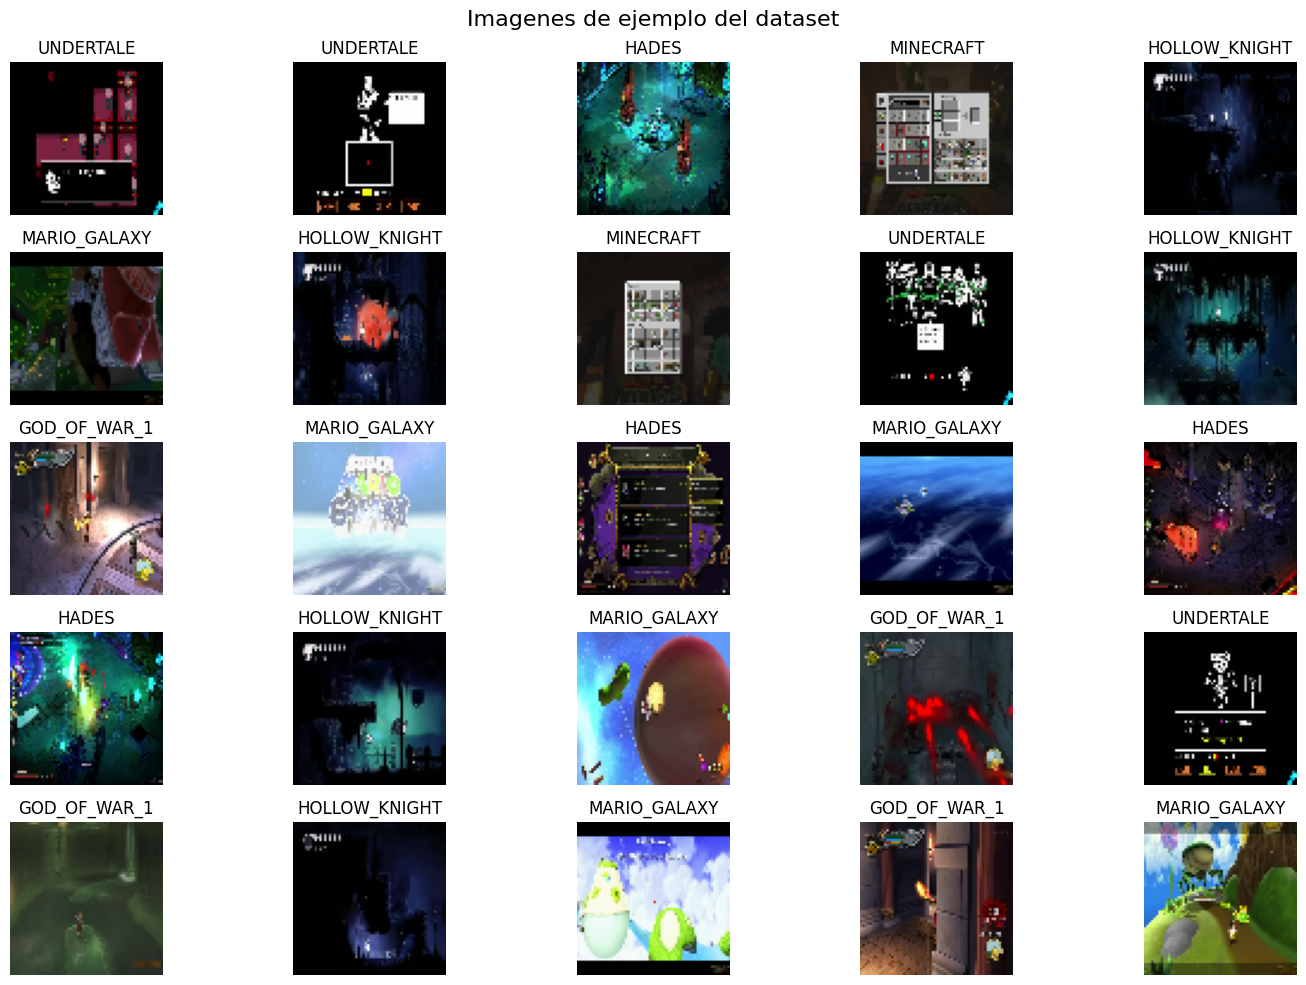

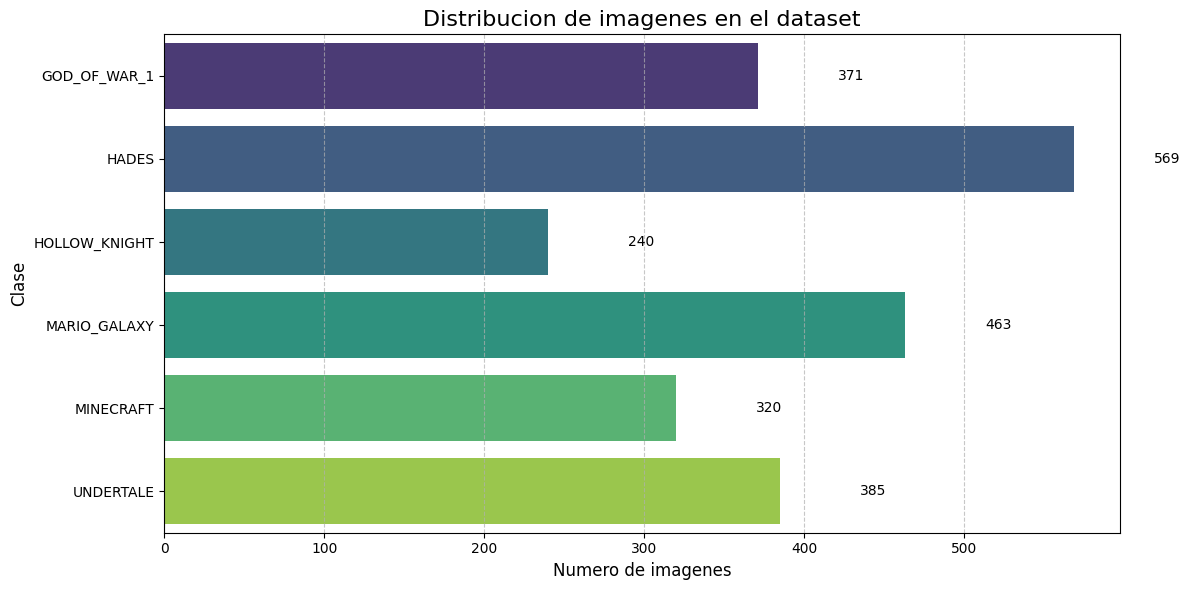

Media de imagenes: 391.33
Desviacion estandar: 114.14


In [21]:
plt.figure(figsize=(15, 10))

# 1. Usamos 'unbatch()' para sacar las imágenes de los paquetes
# 2. Usamos 'take(25)' para coger exactamente las que necesitamos
# 3. Usamos enumerate para saber en qué posición (i) del subplot estamos
for i, (image, label) in enumerate(train_ds.unbatch().take(25)):
    
    ax = plt.subplot(5, 5, i + 1)
    
    # Ya no necesitamos [i] porque 'image' es una sola foto, no un lote
    plt.imshow(image.numpy().astype("uint8"))
    
    # Manejo del label
    # Nota: Dependiendo de tu dataset, label podría ser un escalar o un array de 1 elemento
    label_index = int(label) 
    plt.title(class_names[label_index])
    plt.axis("off")

plt.suptitle("Imagenes de ejemplo del dataset", fontsize=16)
plt.tight_layout()
plt.show()


class_counts = {name: 0 for name in class_names}
for _, labels in full_ds:
    for label in labels:
        class_name = class_names[int(label)]
        class_counts[class_name] += 1

# Lo hacemos con un dataframe, pues es mas facil hacer el plot.
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(12, 6))
bplot = sns.barplot(x='Count', y='Class', data=df_counts, palette='viridis', hue='Class')
# tenemos que quitar la leyenda manualmente porque da error con legend=False
if bplot.get_legend() is not None:
    bplot.get_legend().remove()

plt.title('Distribucion de imagenes en el dataset', fontsize=16)
plt.xlabel('Numero de imagenes', fontsize=12)
plt.ylabel('Clase', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# añadimos el numero al final de la barra para verlo mejor
for index, value in enumerate(df_counts['Count']):
    plt.text(value + 50, index, str(value), va='center')

plt.tight_layout()
plt.show()

mean_count = df_counts['Count'].mean()
std_count = df_counts['Count'].std()
print(f"Media de imagenes: {mean_count:.2f}")
print(f"Desviacion estandar: {std_count:.2f}")

Como podemos observar en el grafico de barras, y confirmado por la media y la desviación, existe un claro desbalance entre los datos, aunque no hay ninguna clase con muchos más datos. Sin embargo la clase Pasture cuenta con bastantes menos datos que las máximas.Esto nos condicionará a la hora de entrenar pues habrá que tener en cuenta aquellas clases que no cuenten con tantos ejemplos.

---
## 3. Baseline: Perceptrón Multicapa (MLP)

Antes de usar redes convolucionales, diseñaremos una red densa clásica (`Sequential`) como baseline para comprobar las limitaciones de tratar imágenes como datos tabulares planos.

**Requisitos:**
1.  La red debe comenzar normalizando los valores de entrada ($0-1$) y aplanando la imagen para convertir la matriz 3D en un vector 1D.
2.  Eres libre de elegir la profundidad y anchura de la red. Ten en cuenta que la entrada tiene más de $12.000$ dimensiones ($64 \times 64 \times 3$).
3.  Configura correctamente la última capa para un problema de clasificación de 10 clases.
4.  Compila el modelo utilizando el optimizador `adam` y la función de pérdida `sparse_categorical_crossentropy`.
5.  Se recomienda guardar el **tiempo de entrenamiento**, en este y todos los modelos, para posibles comparaciones posteriores.
6.  Guarda el mejor modelo generado como `best_mlp.keras`.

**Evaluación:**
1.  Utiliza `accuracy` como métrica de monitorización. Pensad por qué podemos usar esta métrica.
2.  Genera y analiza las gráficas de `loss` y `accuracy` (Entrenamiento vs. Validación).
3.  **Pregunta:** ¿Por qué, teóricamente, un MLP no es la arquitectura ideal para este problema comparado con una CNN?

In [22]:
# Funcion que usamos para imprimir las graficas de los distintos modelos
def plot_history(history, model_name, stop_epoch=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    f1 = history.history['f1_score']
    val_f1 = history.history['val_f1_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc)) 
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training accuracy')
    plt.plot(epochs_range, val_acc, label='Validation accuracy')
    if stop_epoch is not None:
        plt.axvline(x=stop_epoch, color='r', linestyle='--', label=f'Early Stopping (Ep {stop_epoch+1})')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: Accuracy')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, f1, label='Training f1')
    plt.plot(epochs_range, val_f1, label='Validation f1')
    if stop_epoch is not None:
        plt.axvline(x=stop_epoch, color='r', linestyle='--', label=f'Early Stopping (Ep {stop_epoch+1})')
    plt.legend(loc='lower right')
    plt.title(f'{model_name}: F1-score')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de training')
    plt.plot(epochs_range, val_loss, label='Perdida de validation')
    plt.legend(loc='upper right')
    plt.title(f'{model_name}: Perdida')
    plt.grid(True)
    
    plt.tight_layout() # Para que se muestren bien con márgenes

    plt.show()

In [23]:
class SparseF1Score(tf.keras.metrics.F1Score):
    def update_state(self, y_true, y_pred, sample_weight=None):
       
        num_classes = tf.shape(y_pred)[-1]  # numero de clases de la predicción
        y_true = tf.reshape(y_true, [-1])
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes) # Convertimos los enteros (sparse) a One-Hot
        
        super().update_state(y_true_one_hot, y_pred, sample_weight) # Llamamos a la función original con los datos corregidos

In [24]:
def build_mlp_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # El input es alto, ancho y n canales de RGB
        
        # Normalización de las capas (0-255 -> 0-1)
        layers.Rescaling(1./255),
        # 64 * 64 * 3 = 12,288 dimensiones, pero aplanando lo dejamos como un vector
        layers.Flatten(),
        
        # Las capas densas estaran conectadas unas entre otras
        layers.Dense(512, activation='relu'), # rectified linear unit
        layers.Dense(256, activation='relu'), 
        layers.Dense(128, activation='relu'),
        
        # Hay 10 posibles outputs
        layers.Dense(10, activation='softmax') # devuelve probabilidades para cada clase
    ], name="MLP_Baseline")
    
    return model

mlp_model_ES = build_mlp_model()
mlp_model_ES.summary()

mlp_model_ES.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]

)

callbacks_list_mlp = [
    callbacks.EarlyStopping( 
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_mlp.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nMLP con Early Stopping")
start_time = time.time()

history_mlp_ES = mlp_model_ES.fit(
    train_ds,
    epochs=50, # lo ponemos alto y lo parara el early stop.
    validation_data=val_ds,
    callbacks=callbacks_list_mlp
)

end_time = time.time()
mlp_ES_training_time = end_time - start_time
print(f"\Tiempo entrenamiento MLP: {mlp_ES_training_time:.2f} s")

epoch_parada_MLP = len(history_mlp_ES.history['loss']) - 1

Model: "MLP_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               6291968   
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
Total params: 6457482 (24.63 MB)
Trainable params: 645

<>:58: SyntaxWarning: invalid escape sequence '\T'
<>:58: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_55/2268964960.py:58: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Tiempo entrenamiento MLP: {mlp_ES_training_time:.2f} s")


24/25 [===========================>..] - ETA: 0s - loss: 2.0538 - accuracy: 0.4245 - f1_score: 0.4318
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to best_mlp.keras
25/25 [==============================] - 4s 115ms/step - loss: 2.0181 - accuracy: 0.4325 - f1_score: 0.4396 - val_loss: 1.2890 - val_accuracy: 0.5375 - val_f1_score: 0.4665
Epoch 2/50
23/25 [==========================>...] - ETA: 0s - loss: 0.7100 - accuracy: 0.7582 - f1_score: 0.7596
Epoch 2: val_accuracy improved from 0.53750 to 0.76875, saving model to best_mlp.keras
25/25 [==============================] - 0s 18ms/step - loss: 0.6922 - accuracy: 0.7656 - f1_score: 0.7671 - val_loss: 0.7461 - val_accuracy: 0.7688 - val_f1_score: 0.7707
Epoch 3/50
24/25 [===========================>..] - ETA: 0s - loss: 0.4479 - accuracy: 0.8444 - f1_score: 0.8447
Epoch 3: val_accuracy improved from 0.76875 to 0.89688, saving model to best_mlp.keras
25/25 [==============================] - 0s 18ms/step - loss: 0.4465 

#### Sin Early Stopping para comparar entre modelos
Originalmente únicamente lo ejecutábamos con Early Stopping, pero con el fin de visualizar mejor las gráficas y una mejor comparación con otros modelos (a igualdad de épocas), hemos decidido volver a entrenarlo sin Early Stopping.

In [25]:
mlp_model = build_mlp_model()
#mlp_model.summary()

mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]

)

callbacks_list_mlp_no_ES = [
    callbacks.ModelCheckpoint(
        filepath='best_mlp.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nMLP")
start_time = time.time()

history_mlp = mlp_model.fit(
    train_ds,
    epochs=50, 
    validation_data=val_ds,
    callbacks=callbacks_list_mlp_no_ES
)

end_time = time.time()
mlp_training_time = end_time - start_time
print(f"\Tiempo entrenamiento MLP: {mlp_training_time:.2f} s")


MLP
Epoch 1/50


<>:32: SyntaxWarning: invalid escape sequence '\T'
<>:32: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_55/120428246.py:32: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Tiempo entrenamiento MLP: {mlp_training_time:.2f} s")


23/25 [==========================>...] - ETA: 0s - loss: 1.6664 - accuracy: 0.5129 - f1_score: 0.5225
Epoch 1: val_accuracy improved from -inf to 0.79688, saving model to best_mlp.keras
25/25 [==============================] - 2s 26ms/step - loss: 1.5966 - accuracy: 0.5337 - f1_score: 0.5435 - val_loss: 0.6789 - val_accuracy: 0.7969 - val_f1_score: 0.7978
Epoch 2/50
23/25 [==========================>...] - ETA: 0s - loss: 0.5557 - accuracy: 0.8145 - f1_score: 0.8136
Epoch 2: val_accuracy improved from 0.79688 to 0.83750, saving model to best_mlp.keras
25/25 [==============================] - 0s 19ms/step - loss: 0.5527 - accuracy: 0.8181 - f1_score: 0.8173 - val_loss: 0.5563 - val_accuracy: 0.8375 - val_f1_score: 0.8332
Epoch 3/50
23/25 [==========================>...] - ETA: 0s - loss: 0.3475 - accuracy: 0.8940 - f1_score: 0.8940
Epoch 3: val_accuracy improved from 0.83750 to 0.87500, saving model to best_mlp.keras
25/25 [==============================] - 0s 19ms/step - loss: 0.3406 -

#### Gráficas de accuracy y perdida

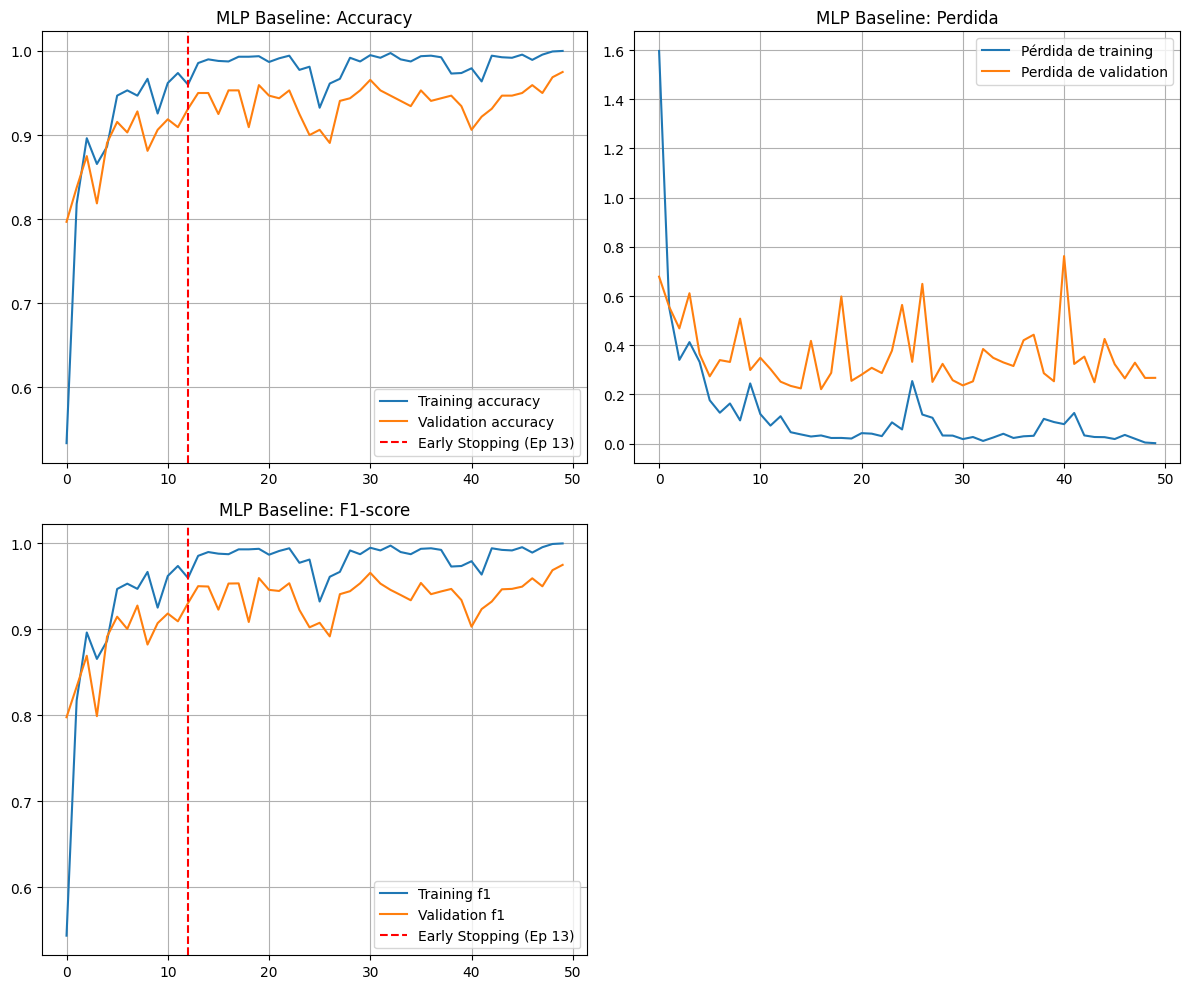

In [26]:
plot_history(history_mlp, "MLP Baseline", epoch_parada_MLP)

#### Tabla comparativa

In [27]:
mlp_val_acc = max(history_mlp.history['val_accuracy'])
mlp_val_f1 = max(history_mlp.history['val_f1_score'])
mlp_time = mlp_training_time

mlpES_val_acc = max(history_mlp_ES.history['val_accuracy'])
mlpES_val_f1 = max(history_mlp_ES.history['val_f1_score'])
mlpES_time = mlp_ES_training_time

print("\n" + "="*50)
print("      COMPARATIVA: MLP con vs sin Early Stopping")
print("="*40)
print(f"{'Métrica':<20} | {'MLP':<15} | {'MLP con ES':<15}")
print("-" * 56)
print(f"{'Tiempo (s)':<20} | {mlp_time:.1f}            | {mlpES_time:.1f}")
print(f"{'Mejor Accuracy':<20} | {mlp_val_acc:.4f}          | {mlpES_val_acc:.4f}")
print(f"{'Mejor F1-Score':<20} | {mlp_val_f1:.4f}          | {mlpES_val_f1:.4f}")


      COMPARATIVA: MLP con vs sin Early Stopping
Métrica              | MLP             | MLP con ES     
--------------------------------------------------------
Tiempo (s)           | 12.9            | 8.0
Mejor Accuracy       | 0.9750          | 0.9375
Mejor F1-Score       | 0.9751          | 0.9377


#### Evaluación
1. Como el desbalance de datos no es muy grave (ninguna clase tiene la gran mayoría de datos), el uso de accuracy no debería ser demasiado perjudicial. Además se puede ver como la gráfica del f1 y la de accuracy son prácticamente iguales.


2. Podemos ver cómo al principio el modelo generaliza muy bien, llegando a superar el accuracy de validation al de training. Sin embargo, a partir de la época 20 (y más aún en la 25) se aprecia un bajón en el accuracy de validation, posiblemente provocado porque el modelo está sobreajustando y aprendiéndose de memoria el dataset. Esta hipótesis se hace más fuerte al comprobar que la pérdida para validation también sufre de picos sobre la época 20 y se mantiene elevada hasta el final.


3. Al aplanar la imágen perdemos información sobre el posicionamiento de cada píxel, que pasan de estar en una matriz  (con vecinos en dos dimensiones), a un vector (solo vecinos en dos lados, una dimensión). Esto provoca que el MLP no pueda aprender formas o texturas. Una CNN puede conservar la matriz 2D, por lo que no cuenta con esta limitación.

    Además, un MLP no tiene resistencia al cambio de posición de objetos en las imágenes, por lo que si aprende lo que es un río que aparece en el lado superior de la imagen, tendrá que volver a aprenderlo para otra imágen en el que salga en la parte inferior. Nuevamente, una CNN no comparte esta limitación, pues tiene la capacidad de reconocer patrones a lo largo de la imagen, no únicamente en una posición.

---
## 4. Arquitectura Propia: Red Neuronal Convolucional (CNN)

Ahora diseñarás una arquitectura adaptada específicamente para el procesamiento de imágenes. Tu objetivo es **superar el rendimiento del Baseline (MLP)** aprovechando la capacidad de las CNN para aprender patrones espaciales y texturas.

Eres libre de definir la profundidad de la red y el número de filtros, pero debes cumplir los siguientes **requisitos**:
1.  **Data Augmentation:** Incluye capas de preprocesamiento al inicio (ej. `RandomFlip`, `RandomRotation`) para mejorar la generalización.
2.  **Estructura:** Se recomienda usar bloques repetitivos de `Conv2D` $\rightarrow$ `MaxPooling2D`.
    * *Advertencia:* Las imágenes son de $64 \times 64$. Si abusas de las capas de *pooling*, reducirás la imagen a $1 \times 1$ antes de tiempo, perdiendo información.
3.  **Regularización:** Es obligatorio implementar `Dropout` y/o `BatchNormalization` para reducir el sobreajuste. Experimenta con su posición y valores.
4.  **Callbacks:** Configura `EarlyStopping` y `ModelCheckpoint`.

**Tarea:**
1.  Diseña, compila y entrena tu modelo.
2.  Compara las curvas de aprendizaje con las del MLP. ¿Converge más rápido? ¿Sufre menos sobreajuste?
3.  Guarda el mejor modelo generado como `best_cnn.keras`.
4.  Compara el ratio entre tamaño del modelo y accuracy del modelo generado (CNN) con el MLP anterior.
5.  Se valorará el estudio de la influencia del aumento de datos y del uso de `Dropout` y/o `BatchNormalization`.

In [28]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds, val_ds, test_ds, class_names, full_ds = do_pipeline(data_dir,IMG_HEIGHT,IMG_WIDTH,BATCH_SIZE)
train_ds, val_ds, test_ds = do_performance(train_ds, val_ds, test_ds)

--- Cargando dataset con tamaño: 224x224 y Batch: 64 ---
Found 2348 files belonging to 6 classes.
Clases encontradas: ['GOD_OF_WAR_1', 'HADES', 'HOLLOW_KNIGHT', 'MARIO_GALAXY', 'MINECRAFT', 'UNDERTALE']
Total batches: 37 -> Train: 25, Val: 5, Test: 7


In [29]:
def build_cnn_model():
    # evitamos memorizar el dataset con data augmentation 
    # Giramos y hacemos zoom aleatorio a las imagenes mientras entrena
    data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # 64x64 pixeles, 3 canales RGB
    
    x = data_augmentation(inputs)

    # 0-255 a 0-1.
    x = layers.Rescaling(1./255)(x)

    # Convoluciones
    
    # Buscamos detalles simples como bordes o esquinas.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # Esto ayuda a estabilizar el aprendizaje
    x = layers.MaxPooling2D((2, 2))(x) # Reducimos la imagen a la mitad, 32x32

    # Buscamos texturas o formas más definidas.
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 4x4

    # Los datos a un vector 
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Hacemos dropout para apagar la mitad de las neuronas al azar y evitar overfitting
    x = layers.Dropout(0.5)(x) 
    
    # 10 outputs
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")
    return model

cnn_model_ES = build_cnn_model()
cnn_model_ES.summary()

cnn_model_ES.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='best_cnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0 
    )
]

print("\nCNN")
start_time_cnn = time.time()

history_cnn_ES = cnn_model_ES.fit(
    train_ds,
    epochs=50, # no deberia llegar a hacer los 50 por el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_cnn,
    verbose=1
)

end_time_cnn = time.time()
cnn_ES_training_time = end_time_cnn - start_time_cnn
print(f"\nTiempo de entrenamiento CNN: {cnn_ES_training_time:.2f} s")
epoch_parada_CNN = len(history_cnn_ES.history['loss']) - 1

Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0

#### Sin Early Stopping

In [30]:
callbacks_list_cnn_no_ES = [
    callbacks.ModelCheckpoint(
        filepath='best_cnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0 
    )
]

cnn_model = build_cnn_model()
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

print("\nCNN sin Early Stopping")
start_time_cnn = time.time()

history_cnn = cnn_model.fit(
    train_ds,
    epochs=50, 
    validation_data=val_ds,
    callbacks=callbacks_list_cnn_no_ES,
    verbose=1
)

end_time_cnn = time.time()
cnn_training_time = end_time_cnn - start_time_cnn
print(f"\nTiempo de entrenamiento CNN sin Early Stop: {cnn_training_time:.2f} s")


Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0

In [31]:
# COMPARACION DE EFICIENCIA ENTRE CNN Y MLP
# Intentamos recuperar los datos del MLP anterior para comparar.
# Si no existen (por no haber corrido esa celda), ponemos ceros para que no falle el código.
try:
    mlp_val_acc = max(history_mlp.history['val_accuracy'])
    mlp_val_f1 = max(history_mlp.history['val_f1_score'])
    mlp_time = mlp_model.count_params()
except NameError:
    mlp_val_acc = 0.0 
    mlp_val_f1 = 0.0
    mlp_time = 0    

cnn_val_acc = max(history_cnn.history['val_accuracy'])
cnn_val_f1 = max(history_cnn.history['val_f1_score'])
cnn_params = cnn_model.count_params()

print("\n" + "="*40)
print("      COMPARATIVA: MLP vs CNN")
print("="*40)
print(f"{'Métrica':<20} | {'MLP':<15} | {'CNN Propia':<15}")
print("-" * 56)
print(f"{'Nº Parámetros':<20} | {mlp_time:<15,} | {cnn_params:<15,}")
print(f"{'Mejor Accuracy':<20} | {mlp_val_acc:.4f}          | {cnn_val_acc:.4f}")
print(f"{'Mejor F1-Score':<20} | {mlp_val_f1:.4f}          | {cnn_val_f1:.4f}")


if cnn_params > 0 and mlp_time > 0:
    ratio_mlp = mlp_time / mlp_val_acc
    ratio_cnn = cnn_params / cnn_val_acc
    print("-" * 56)
    print(f"{'Eficiencia':<20} | {int(ratio_mlp):<15,} | {int(ratio_cnn):<15,} (menos mejor)")


      COMPARATIVA: MLP vs CNN
Métrica              | MLP             | CNN Propia     
--------------------------------------------------------
Nº Parámetros        | 6,457,482       | 26,086,090     
Mejor Accuracy       | 0.9750          | 0.9250
Mejor F1-Score       | 0.9751          | 0.9247
--------------------------------------------------------
Eficiencia           | 6,623,058       | 28,201,178      (menos mejor)


#### Comparación entre CNN y MLP

Como vemos en la tabla, la CNN cuenta con muchos menos parámetros y un accuracy bastante superior. Esto nos lleva a una mucha mejor eficiencia para el CNN.

#### Gráficas de accuracy y perdida

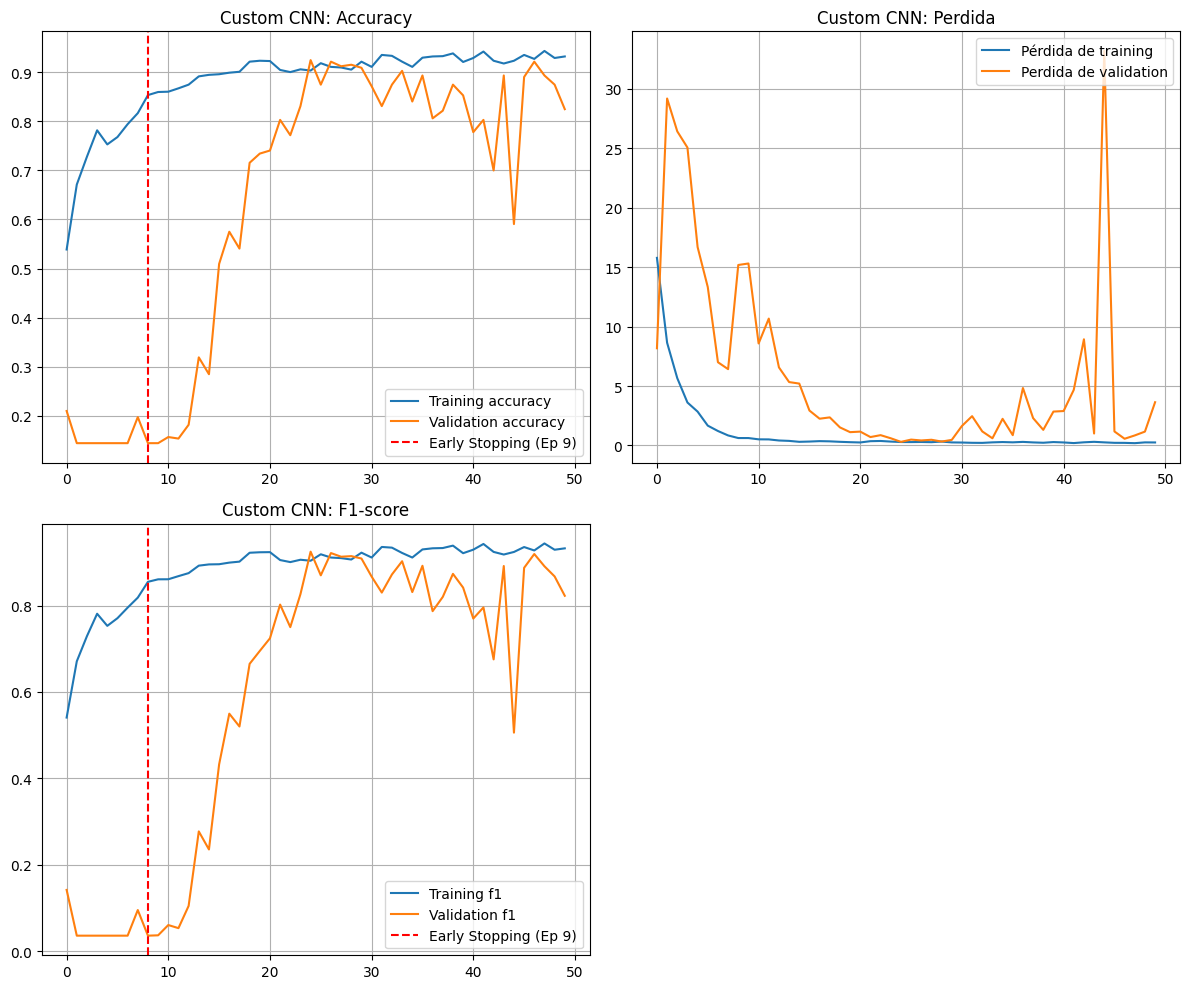

In [32]:
plot_history(history_cnn, "Custom CNN", epoch_parada_CNN)

#### Evaluación
Las gráficas demuestran que nuestra CNN sigue haciendo un poco de overfitting, pues la validación sigue estando por debajo del training. Sin embargo, esta vez la diferencia entre el validation y el training es constante a lo largo de las épocas. También podemos observar que el validation tiene muchos picos. Pensamos que esto ocurre por existir lotes de imágenes más "confusas" y otras más fáciles para el modelo. En el train esto no afecta tanto pues las imágenes se modifican con el data augmentation, pero  el validation al usar imágenes "limpias" es más sensible a este efecto. 

En adición, comparando con el MLP anterior vemos como la CNN ya obtiene mejores resultados en sus primeras épocas, por lo que aprende más características más útiles y más rápido. Además la CNN tiene un sobreajuste que no aumenta con el tiempo, como sí ocurría con el MLP.

### Estudio de Data Augmentation, Normalizacion y Dropout

#### Sin Data Augmentation

In [33]:
def build_cnn_model_without_DA():
    # evitamos memorizar el dataset con data augmentation 
    # Giramos y hacemos zoom aleatorio a las imagenes mientras entrena
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # 64x64 pixeles, 3 canales RGB
    
    x = inputs

    # 0-255 a 0-1.
    x = layers.Rescaling(1./255)(x)

    # Convoluciones
    
    # Buscamos detalles simples como bordes o esquinas.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # Esto ayuda a estabilizar el aprendizaje
    x = layers.MaxPooling2D((2, 2))(x) # Reducimos la imagen a la mitad, 32x32

    # Buscamos texturas o formas más definidas.
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 4x4

    # Los datos a un vector 
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Hacemos dropout para apagar la mitad de las neuronas al azar y evitar overfitting
    x = layers.Dropout(0.5)(x) 
    
    # 10 outputs
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")
    return model

cnn_model = build_cnn_model_without_DA()
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
]

print("\nCNN sin DA")
start_time_cnn_w_DA = time.time()

history_cnn_without_DA = cnn_model.fit(
    train_ds,
    epochs=50, # no deberia llegar a hacer los 50 por el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_cnn,
    verbose=1
)

end_time_cnn = time.time()
cnn_training_time_w_DA = end_time_cnn - start_time_cnn_w_DA
print(f"\nTiempo de entrenamiento CNN: {cnn_training_time_w_DA:.2f} s")

Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      1

#### Sin Normalizacion

In [34]:
def build_cnn_model_without_N():
    # evitamos memorizar el dataset con data augmentation 
    # Giramos y hacemos zoom aleatorio a las imagenes mientras entrena
    data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # 64x64 pixeles, 3 canales RGB
    
    x = data_augmentation(inputs)

    # 0-255 a 0-1.
    x = layers.Rescaling(1./255)(x)

    # Convoluciones
    
    # Buscamos detalles simples como bordes o esquinas.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # Esto ayuda a estabilizar el aprendizaje
    x = layers.MaxPooling2D((2, 2))(x) # Reducimos la imagen a la mitad, 32x32

    # Buscamos texturas o formas más definidas.
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 4x4

    # Los datos a un vector 
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    # Hacemos dropout para apagar la mitad de las neuronas al azar y evitar overfitting
    x = layers.Dropout(0.5)(x) 
    
    # 10 outputs
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")
    return model

cnn_model = build_cnn_model_without_N()
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
]

print("\nCNN")
start_time_cnn = time.time()

history_cnn_without_normalization = cnn_model.fit(
    train_ds,
    epochs=50, # no deberia llegar a hacer los 50 por el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_cnn,
    verbose=1
)

end_time_cnn = time.time()
cnn_training_time = end_time_cnn - start_time_cnn
print(f"\nTiempo de entrenamiento CNN: {cnn_training_time:.2f} s")

Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_16 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 112, 112, 32)      0

#### Sin dropout

In [35]:
def build_cnn_model_without_dropout():
    # evitamos memorizar el dataset con data augmentation 
    # Giramos y hacemos zoom aleatorio a las imagenes mientras entrena
    data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")
    
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # 64x64 pixeles, 3 canales RGB
    
    x = data_augmentation(inputs)

    # 0-255 a 0-1.
    x = layers.Rescaling(1./255)(x)

    # Convoluciones
    
    # Buscamos detalles simples como bordes o esquinas.
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x) # Esto ayuda a estabilizar el aprendizaje
    x = layers.MaxPooling2D((2, 2))(x) # Reducimos la imagen a la mitad, 32x32

    # Buscamos texturas o formas más definidas.
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 16x16

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 8x8

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) # Bajamos a 4x4

    # Los datos a un vector 
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)    
    
    # 10 outputs
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Custom_CNN")
    return model

cnn_model = build_cnn_model_without_dropout()
cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_list_cnn = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
]

print("\nCNN")
start_time_cnn = time.time()

history_cnn_without_dropout = cnn_model.fit(
    train_ds,
    epochs=50, # no deberia llegar a hacer los 50 por el early stop
    validation_data=val_ds,
    callbacks=callbacks_list_cnn,
    verbose=1
)

end_time_cnn = time.time()
cnn_training_time = end_time_cnn - start_time_cnn
print(f"\nTiempo de entrenamiento CNN: {cnn_training_time:.2f} s")

Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_17 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 112, 112, 32)      0

#### Gráficas

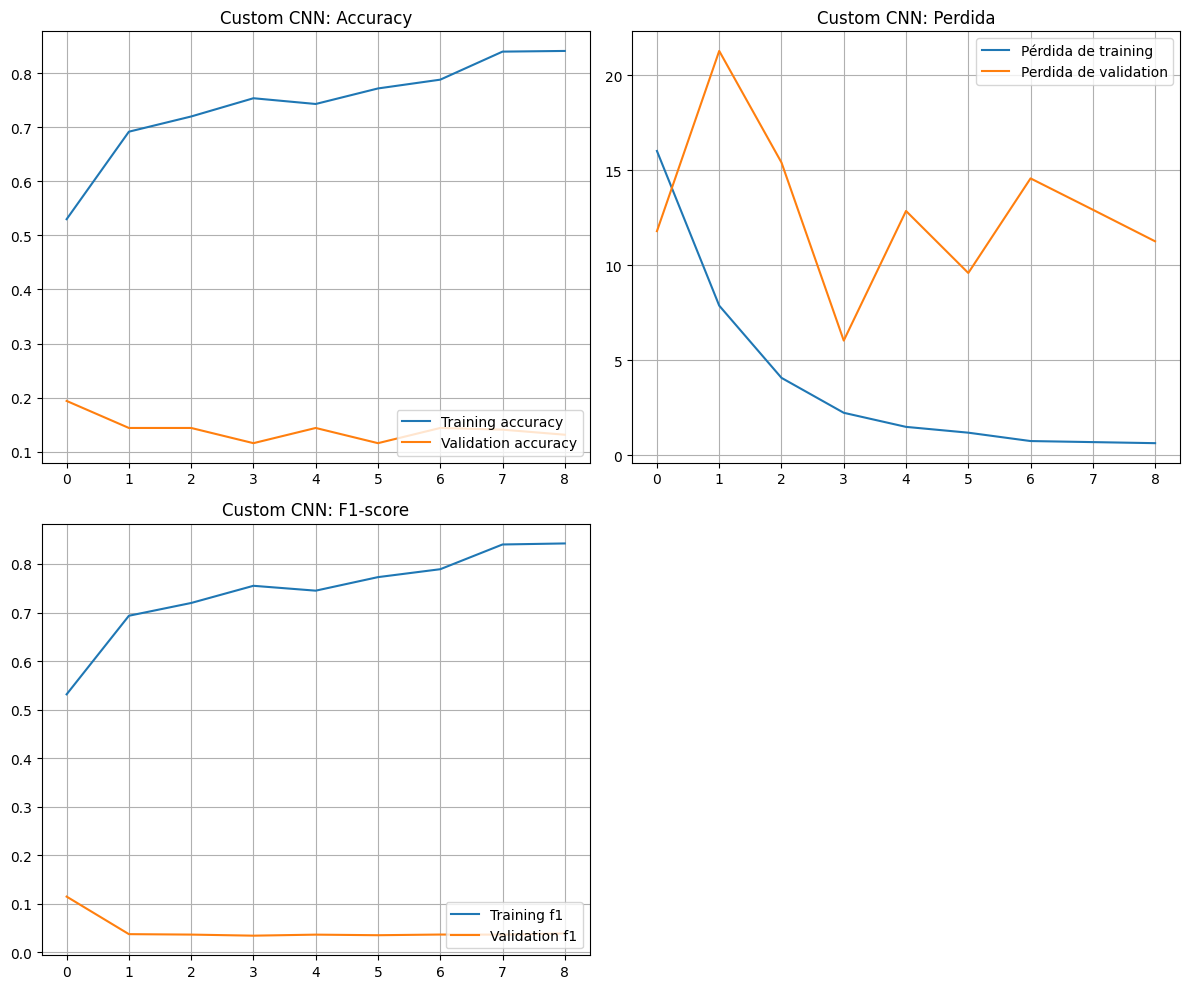

In [36]:
#Original para comparar
plot_history(history_cnn_ES, "Custom CNN")

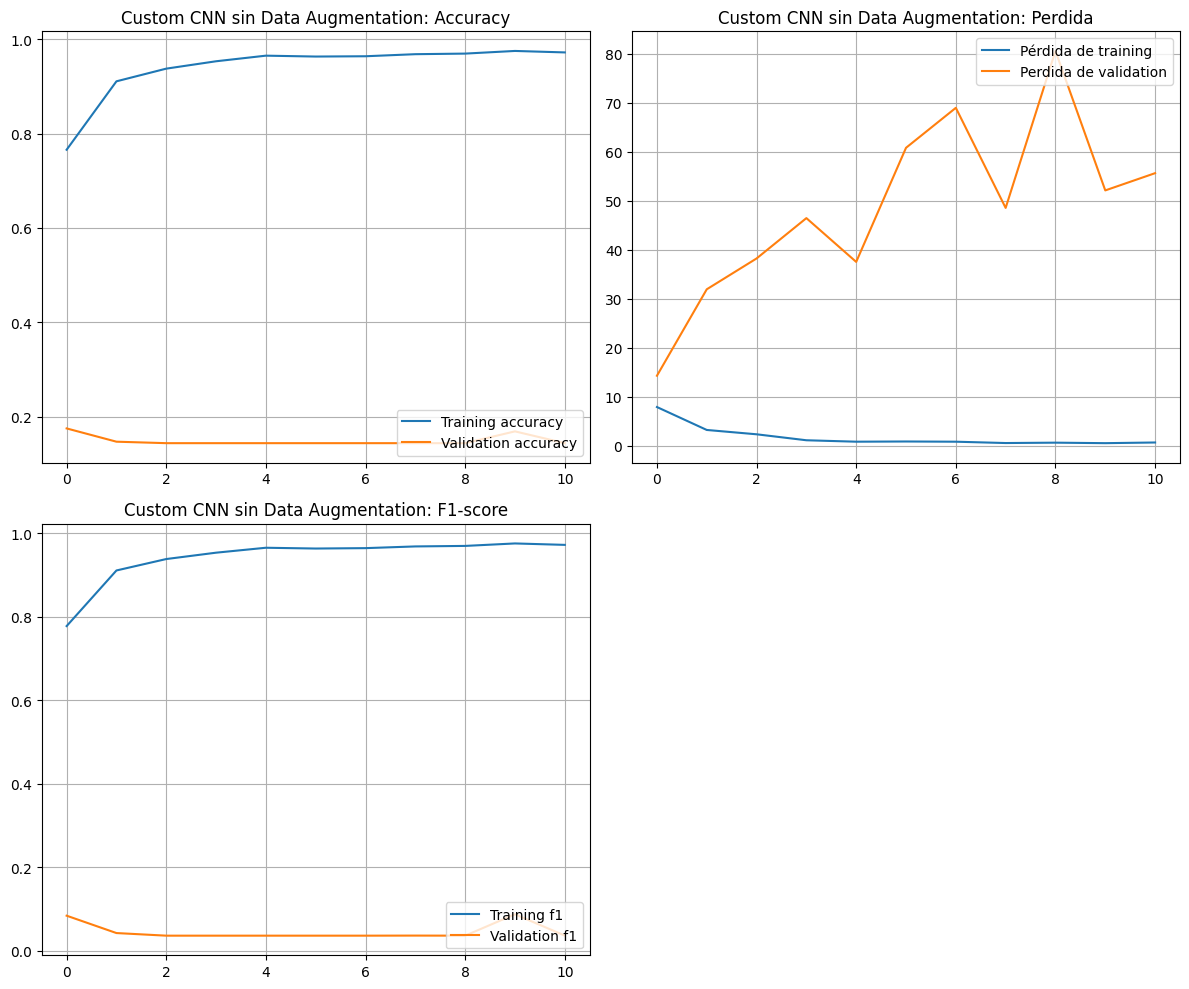

In [37]:
plot_history(history_cnn_without_DA, "Custom CNN sin Data Augmentation")


Vemos que al eliminar el data augmentation (y por tanto las rotaciones y los zooms aleatorios), la red se aprende de memoria las características en vez de generalizar, lo que lleva a un mayor puntuaje en training y menor en validation (overfitting). Además podemos ver que los picos han aumentado, posiblemente a causa del gran overfitting que tiene el modelo sin aplicar un data augmentation.

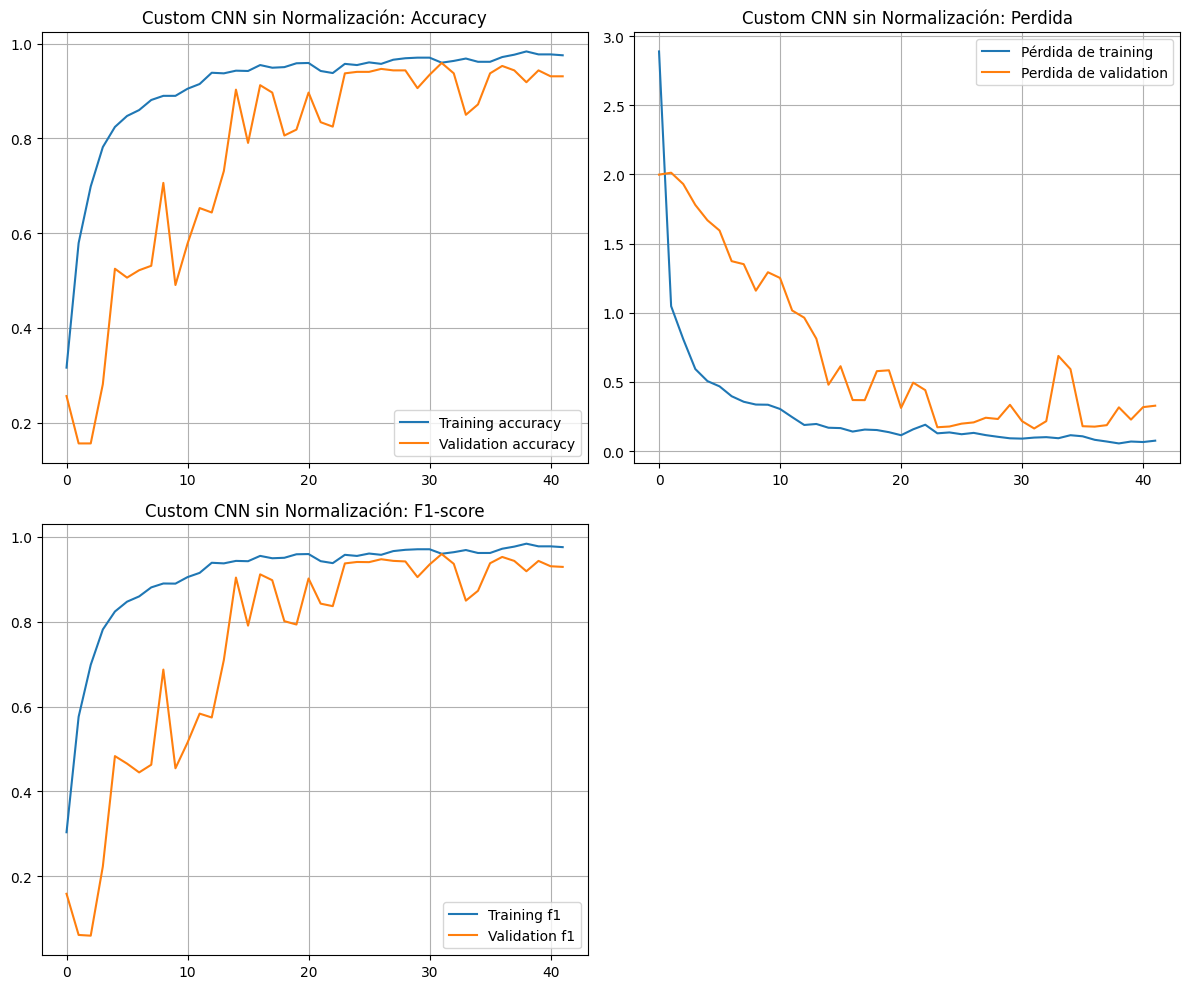

In [38]:
plot_history(history_cnn_without_normalization, "Custom CNN sin Normalización")

Vemos que sin aplicar Batch Normalization el modelo se vuelve muy inestable en sus predicciones de validation. Esto puede deberse a que los pesos de la red cambian demasiado bruscamente, haciendo que el gradiente sea inestable. En adición, el modelo tarda más en aprender, posiblemente por estos cambios tan bruscos de parámetros.

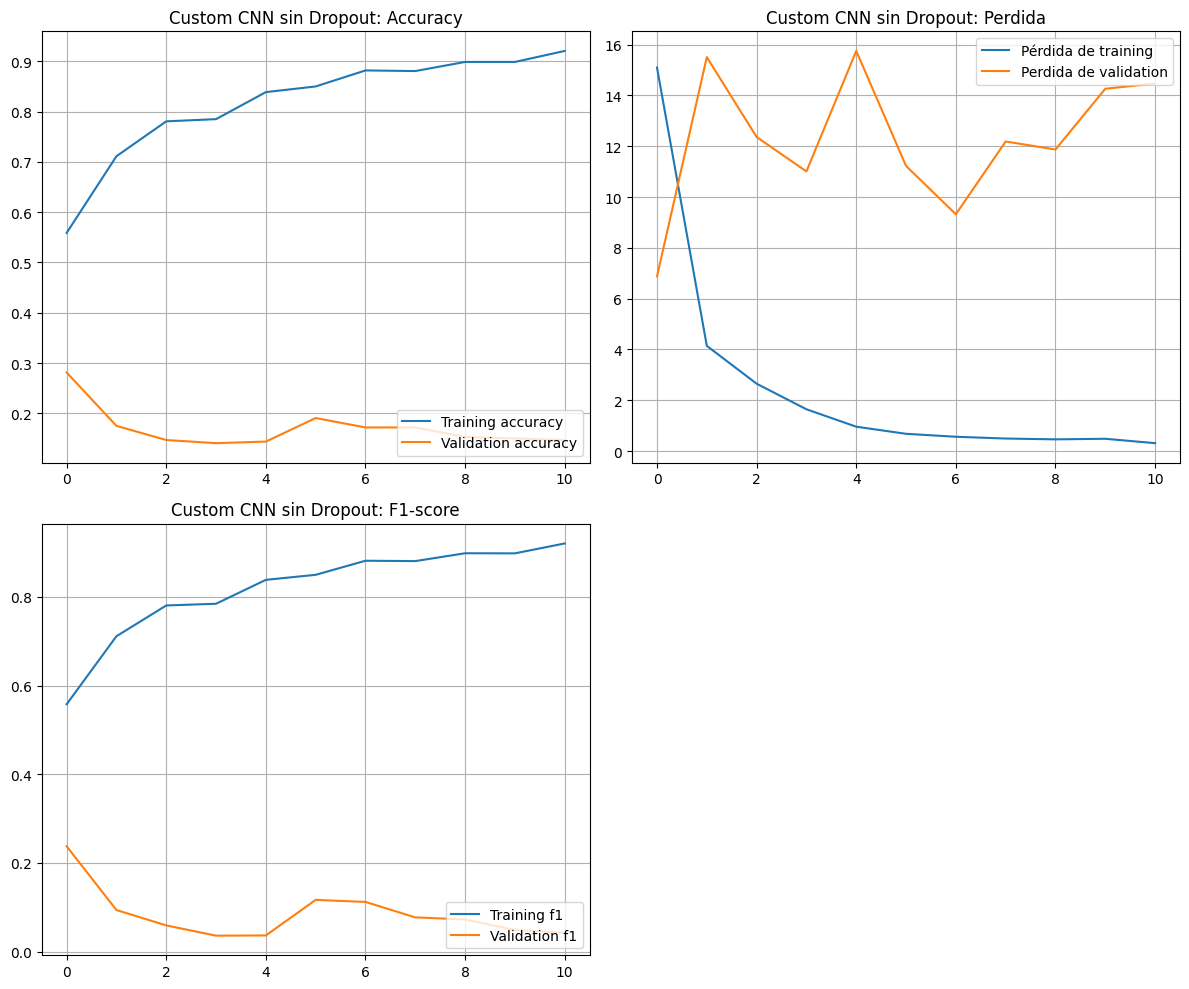

In [39]:
plot_history(history_cnn_without_dropout, "Custom CNN sin Dropout")

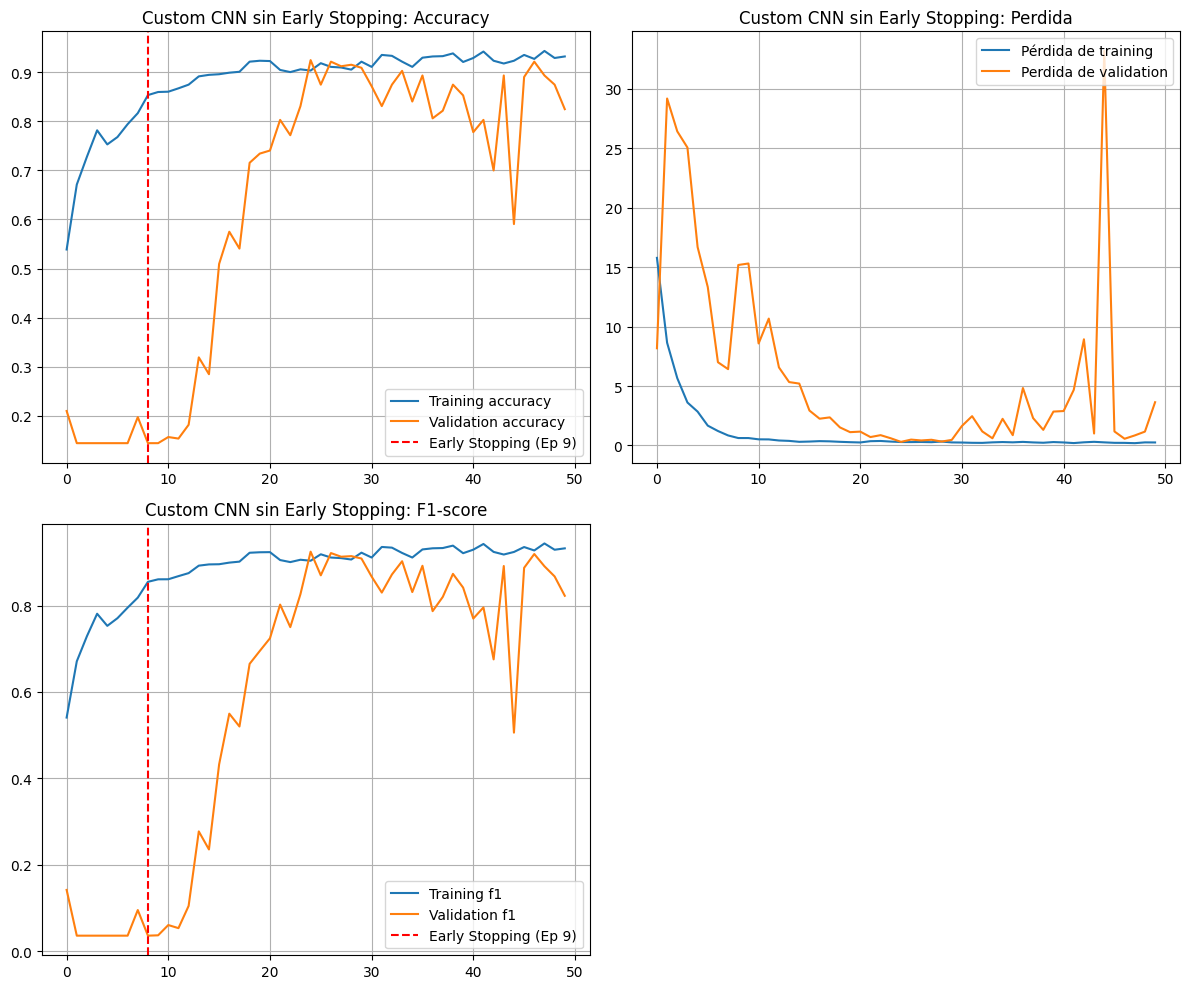

In [40]:
plot_history(history_cnn, "Custom CNN sin Early Stopping", epoch_parada_CNN)

Con estas gráficas podemos validar que el no desactivar neuronas provoca un mayor overfitting (pues hay mayor separación entre validation y training), ya que el modelo se fija más en ciertas características en vez de generalizar. Por otro lado, podemos observar que al activar Early Stopping, el modelo no habria llegado a un estado en el que es mas preciso, a coste de un mayor overfitting.

---
## 5. Transfer Learning (Estado del Arte)

En esta sección, utilizaremos una red preentrenada en ImageNet para aprovechar el conocimiento extraído de millones de imágenes. Dado el tamaño de entrada ($64 \times 64$), buscamos arquitecturas eficientes que no reduzcan excesivamente la dimensionalidad espacial.

Debes construir un nuevo modelo siguiendo estas **pautas**:
1.  Integra la misma capa de aumento de datos definida en la sección anterior.
2.  Importa una arquitectura robusta (como `ResNet50V2` o `EfficientNetV2B0`) con pesos de `imagenet`. Recuerda configurar `include_top=False` y definir el `input_shape` correcto.
3.  Congela los pesos del modelo base (Feature Extraction) y añade tu(s) propia(s) capa(s) completamente contectada(s) para clasificación. Se recomienda usar `GlobalAveragePooling2D` para conectar la base convolucional con la capa de salida.

**Tarea:**
1.  Construye, compila y entrena el modelo.
2.  Guarda el mejor modelo generado como `best_transfer.keras`.
3.  Analiza si el uso de modelos preentrenados justifica la mejora en precisión respecto a tu CNN "artesanal", considerando el tiempo de entrenamiento y el número de parámetros.
4.  Se valorará el estudio de descongelar los últimos bloques del modelo base para realizar un *Fine-Tuning* con una tasa de aprendizaje reducida (ej. $1e-5$).

In [44]:
# Usar un modelo que ya sabe ver (pre-entrenado por Google) y adaptarlo.

def build_transfer_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.1)(x)
    
    # EfficientNet ya trae de serie la normalización de pixeles asi que nos la saltamos
    
    base_model = EfficientNetV2B0(
        include_top=False, 
        weights='imagenet', 
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freezing para que no entrene nada nuevo
    base_model.trainable = False
    
    # Conectamos nuestra entrada al modelo base, training=False para que las estadísticas internas del modelo sean con nuestros datos
    x = base_model(x, training=False)
    

    # El modelo base nos devuelve un montón de mapas de características, asi que hacemos la media de
    # todo en un vector de 1280 números por imagen.
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.Dropout(0.2)(x) # También apagamos neuronas al azar para evitar overfitting
    outputs = layers.Dense(10, activation='softmax')(x) # 10 clases finales
    
    model = keras.Model(inputs, outputs, name="Transfer_EfficientNetV2")
    return model, base_model

transfer_model, base_model = build_transfer_model()
transfer_model.summary()

transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_transfer = [
    # Si no mejora en 5 capas se para
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    #callbacks.ModelCheckpoint('best_transfer.keras', monitor='val_accuracy', save_best_only=True, verbose=0) Es mejor sin ES, asi que lo hacemos ahí
]

print("\nFeature Extraction")
start_time = time.time()

history_tl_ES = transfer_model.fit(
    train_ds,
    epochs=25, # como aprende rápido no necesitamos un numero tan alto
    validation_data=val_ds,
    callbacks=callbacks_transfer
)

# FINETUNING 

# Descongelamos
base_model.trainable = True
# Usamos una velocidad de aprendizaje muy pequeña (1e-5), pues con una velocidad mas alta se pdoria sobreescribir el 
# aprendizaje que era correcto
transfer_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_finetune = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    # Seguimos guardando si superamos el récord
    #callbacks.ModelCheckpoint('best_transfer.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
]

print("\nFINETUNING:")
history_finetune_ES = transfer_model.fit(
    train_ds,
    epochs=50, 
    initial_epoch=history_tl_ES.epoch[-1],
    validation_data=val_ds,
    callbacks=callbacks_finetune
)

end_time = time.time()
tl_training_time_ES = end_time - start_time
print(f"\nTiempo total (Extraction + FineTuning): {tl_training_time_ES:.2f} segundos")

acc_ES = history_tl_ES.history['accuracy'] + history_finetune_ES.history['accuracy']
val_acc_ES = history_tl_ES.history['val_accuracy'] + history_finetune_ES.history['val_accuracy']
f1_ES = history_tl_ES.history['f1_score'] + history_finetune_ES.history['f1_score']
val_f1_ES = history_tl_ES.history['val_f1_score'] + history_finetune_ES.history['val_f1_score']
loss_ES = history_tl_ES.history['loss'] + history_finetune_ES.history['loss']
val_loss_ES = history_tl_ES.history['val_loss'] + history_finetune_ES.history['val_loss']

Model: "Transfer_EfficientNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_8 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_8 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d_3  (None, 1280)  

#### Transfer Learning sin Early Stopping

In [46]:
transfer_model, base_model = build_transfer_model()
transfer_model.summary()

transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_transfer = [
    # Si no mejora en 5 capas se para
    callbacks.ModelCheckpoint('best_transfer.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
] 

print("\nFeature Extraction")
start_time = time.time()

history_tl = transfer_model.fit(
    train_ds,
    epochs=25, # como aprende rápido no necesitamos un numero tan alto
    validation_data=val_ds,
    callbacks=callbacks_transfer
)

# FINETUNING 

# Descongelamos
base_model.trainable = True
# Usamos una velocidad de aprendizaje muy pequeña (1e-5), pues con una velocidad mas alta se pdoria sobreescribir el 
# aprendizaje que era correcto
transfer_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_finetune = [
    # Seguimos guardando si superamos el récord
    callbacks.ModelCheckpoint('best_transfer.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
] 

print("\nFINETUNING:")
history_finetune = transfer_model.fit(
    train_ds,
    epochs=50, 
    initial_epoch=history_tl.epoch[-1],
    validation_data=val_ds,
    callbacks=callbacks_finetune
)

end_time = time.time()
tl_training_time = end_time - start_time
print(f"\nTiempo total (Extraction + FineTuning): {tl_training_time:.2f} segundos")

acc = history_tl.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_tl.history['val_accuracy'] + history_finetune.history['val_accuracy']
f1 = history_tl.history['f1_score'] + history_finetune.history['f1_score']
val_f1 = history_tl.history['val_f1_score'] + history_finetune.history['val_f1_score']
loss = history_tl.history['loss'] + history_finetune.history['loss']
val_loss = history_tl.history['val_loss'] + history_finetune.history['val_loss']

Model: "Transfer_EfficientNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_10 (RandomFlip  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 random_rotation_10 (Random  (None, 224, 224, 3)       0         
 Rotation)                                                       
                                                                 
 random_zoom_10 (RandomZoom  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                      

#### Visualizar graficas y comparativa final

In [48]:
def plt_transfer_learning(acc,val_acc, history_tl, loss, val_loss, f1, val_f1): # Para el plot de transfer learning
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(acc, label='Training accuracy')
    plt.plot(val_acc, label='Validation accuracy')
    plt.plot([len(history_tl.history['accuracy'])-1,len(history_tl.history['accuracy'])-1], 
            plt.ylim(), label='Inicio Fine Tuning', ls='--') 
    plt.legend(loc='lower right')
    plt.title('Evolución de accuracy de Transfer Learning')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(f1, label='Training F1-score')
    plt.plot(val_f1, label='Validation F1-score')
    plt.plot([len(history_tl.history['f1_score'])-1,len(history_tl.history['f1_score'])-1], 
            plt.ylim(), label='Inicio Fine Tuning', ls='--') 
    plt.legend(loc='lower right')
    plt.title('Evolución de F1-score de Transfer Learning')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(loss, label='Pérdida en training')
    plt.plot(val_loss, label='Pérdida en validation')
    plt.plot([len(history_tl.history['loss'])-1,len(history_tl.history['loss'])-1], 
            plt.ylim(), label='Inicio Fine Tuning', ls='--')
    plt.legend(loc='upper right')
    plt.title('Evolución de la pérdida de Transfer Learning')
    plt.grid(True)
    plt.show()

In [50]:
# Comparativa 

# Intentamos recuperar métricas de los modelos anteriores (si existen en memoria)
try:
    mlp_acc = max(history_mlp.history['val_accuracy'])
    cnn_ES_acc = max(history_cnn_ES.history['val_accuracy'])
    cnn_acc = max(history_cnn.history['val_accuracy'])
    mlp_f1 = max(history_mlp.history['val_f1_score'])
    cnn_ES_f1 = max(history_cnn_ES.history['val_f1_score'])
    cnn_f1 = max(history_cnn.history['val_f1_score'])
    mlp_par = mlp_model.count_params()
    cnn_ES_par = cnn_model.count_params()
    cnn_par = cnn_model.count_params()
    

    mlp_acc_ES = max(history_mlp_ES.history['val_accuracy'])
    mlp_f1_ES = max(history_mlp_ES.history['val_f1_score'])
    mlp_par_ES = mlp_model_ES.count_params()
except NameError:
    mlp_acc, cnn_ES_acc, cnn_acc, mlp_f1, cnn_f1_ES, cnn_f1, mlp_par, cnn_par_ES, cnn_par= 0, 0, 0, 0 # Ponemos ceros si no se corrieron antes

tl_acc = max(val_acc)
tl_f1 = max(val_f1)
tl_par = transfer_model.count_params()

tl_acc_ES = max(val_acc_ES)
tl_f1_ES = max(val_f1_ES)
tl_par_ES = transfer_model.count_params()

print("\n" + "="*60)
print("      COMPARATIVA FINAL DE ARQUITECTURAS (Sin Early Stopping)")
print("="*60)
print(f"{'Modelo':<20} | {'Parámetros':<12} | {'Val Acc':<10} | {'Val F1':<10} | {'Tiempo(s)':<10}")
print("-" * 60)
print(f"{'MLP (Básico)':<20} | {mlp_par:<12,} | {mlp_acc:.4f}   | {mlp_f1:.4f}     | {mlp_training_time if 'mlp_training_time' in locals() else 0:.1f}")
print(f"{'MLP (con Early Stop)':<20}  | {mlp_par_ES:<12,} | {mlp_acc_ES:.4f}   | {mlp_f1_ES:.4f}     | {mlp_ES_training_time if 'mlp_ES_training_time' in locals() else 0:.1f}")
print(f"{'CNN':<20} | {cnn_par:<12,}  | {cnn_acc:.4f}   | {cnn_f1:.4f}     | {cnn_training_time if 'cnn_training_time' in locals() else 0:.1f}")
print(f"{'CNN (Con Early Stop)':<20}  | {cnn_ES_par:<12,} | {cnn_ES_acc:.4f}   | {cnn_ES_f1:.4f}     | {cnn_ES_training_time if 'cnn_training_time' in locals() else 0:.1f}")
print(f"{'Transfer Learning':<20}     | {tl_par:<12,} | {tl_acc:.4f}   | {tl_f1:.4f}     | {tl_training_time:.1f}")
print(f"{'Transfer Learning (con ES)':<20} | {tl_par_ES:<12,} | {tl_acc_ES:.4f}   | {tl_f1_ES:.4f}     | {tl_training_time_ES:.1f}")
print("-" * 60)


      COMPARATIVA FINAL DE ARQUITECTURAS (Sin Early Stopping)
Modelo               | Parámetros   | Val Acc    | Val F1     | Tiempo(s) 
------------------------------------------------------------
MLP (Básico)         | 6,457,482    | 0.9750   | 0.9751     | 12.9
MLP (con Early Stop)  | 6,457,482    | 0.9375   | 0.9377     | 8.0
CNN                  | 26,086,090    | 0.9250   | 0.9247     | 50.6
CNN (Con Early Stop)  | 26,086,090   | 0.1937   | 0.1145     | 50.7
Transfer Learning        | 5,932,122    | 0.9844   | 0.9844     | 411.5
Transfer Learning (con ES) | 5,932,122    | 0.9812   | 0.9813     | 394.1
------------------------------------------------------------


#### Gráficas con Early Stopping

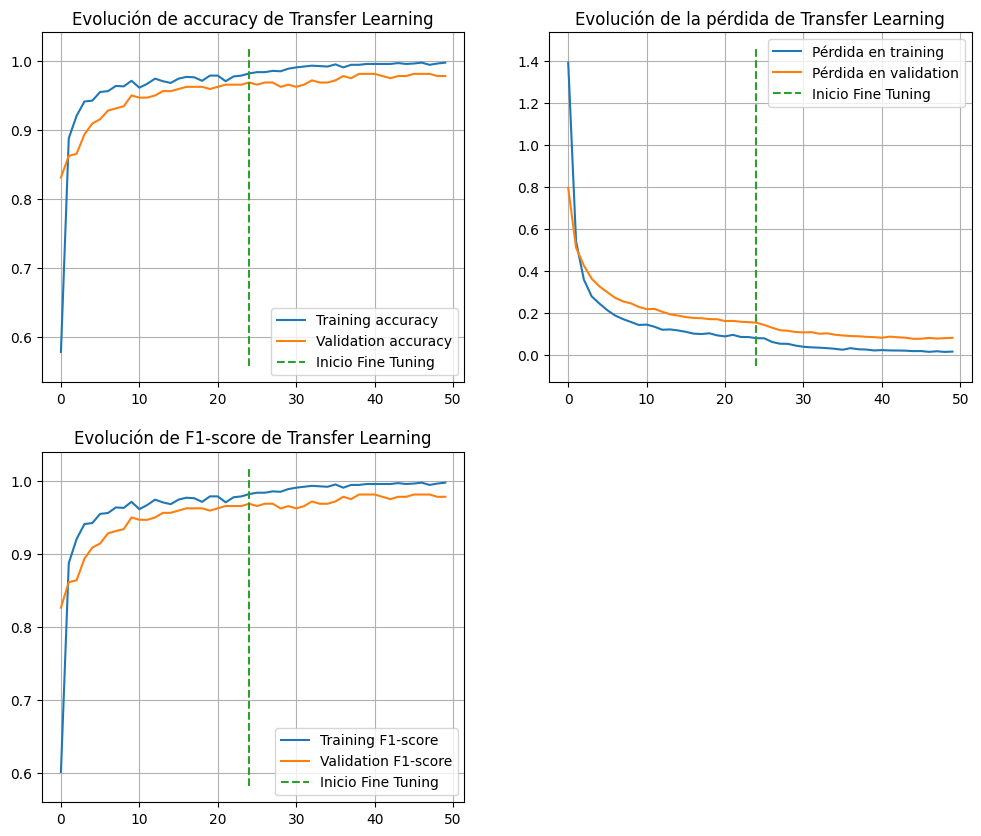

In [49]:
plt_transfer_learning(acc_ES, val_acc_ES, history_tl_ES, loss_ES, val_loss_ES, f1_ES, val_f1_ES)

#### Gráficas SIN Early Stopping

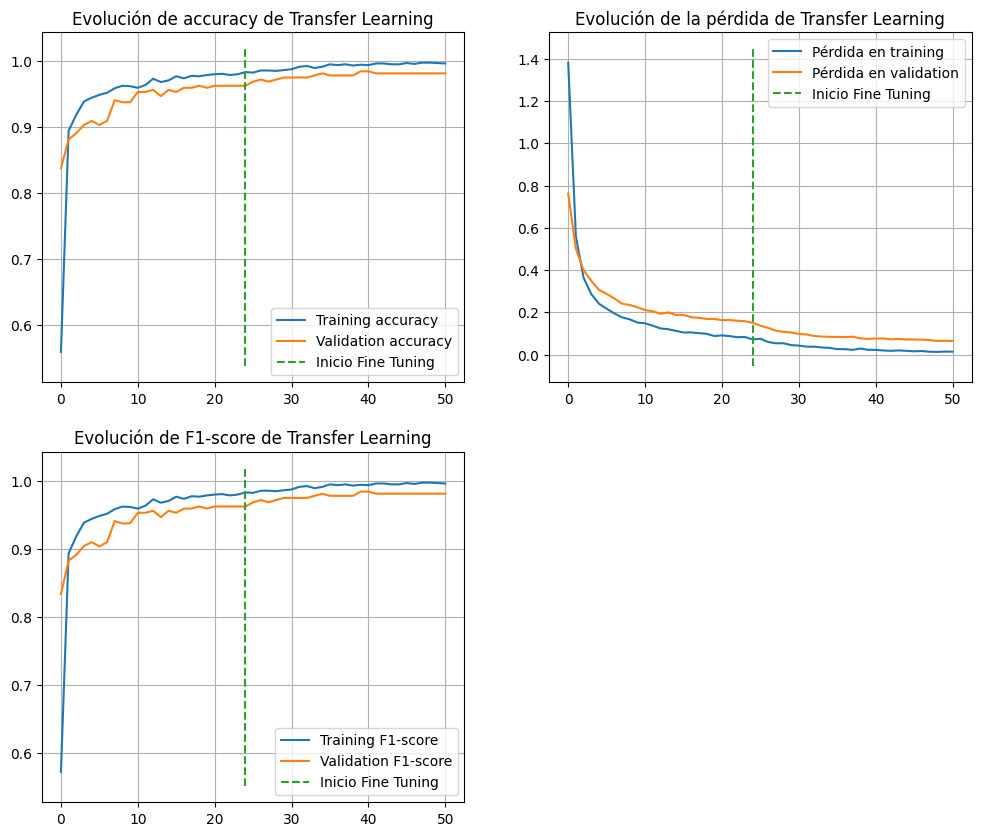

In [51]:
plt_transfer_learning(acc, val_acc, history_tl, loss, val_loss, f1, val_f1)

La mayor diferencia de estas gráficas frente a nuestra CNN propia es que empieza con un accuracy bastante más alto. Esto puede deberse al hehco de que el modelo ya viene pre-entrenado, y por tanto ya sabe distinguir ciertas formas y texturas. Además no tiene nada de overfitting pues el accuracy de validation es mayor al de train (y su pérdida menor). Al hacer el fine tuning se ve que mejora drásticamente tanto en validation como en train, posiblemente por adaptar los valores previamente congelados a las características de nuestro dataset. Por ultimo, tenemos el mismo caso que antes, al activar la opción Early Stopping el modelo tendra algo menos de precision, sin embargo conforme avanzan las epocas vemos aun más overfitting en el modelo. Antes de que saltara el ES, el modelo no hacia practicamente overfitting, como hemos dicho antes, sin embargo tras el fine tunning y ES combinados el resultado final no sería tan ajustado para otros dataset, dandole menos utilidad real.

Aunque este modelo consigue una mejor accuracy que nuestra CNN, también tarda el doble y usa bastantes más parámetros, por lo que en la mayoría de casos nuestra CNN sería un buen compromiso entre recursos y rendimiento. En comparación con el MLP, este Transfer Learning es mucho mejor, pues sigue teniendo menos que el MLP mientras consigue un rendimiento bastante superior.

---
## 6. (Opcional) Nuevas Fronteras: Vision Transformers (ViT)

Mientras que las CNN han dominado la visión por computador durante una década, los **Transformers** (originalmente diseñados para texto) han irrumpido con fuerza en el campo.

A diferencia de una CNN, que mira píxeles vecinos, un **Vision Transformer (ViT)** divide la imagen en "parches" (por ejemplo, cuadrados de $16 \times 16$) y procesa la relación de cada parche con todos los demás simultáneamente mediante mecanismos de **Atención**.

**Desafío Técnico:**
Los ViT son modelos muy pesados y requieren una resolución de entrada específica (generalmente $224 \times 224$). Además, su integración en Keras requiere adaptadores especiales.

**Tarea (Bonus):**
1.  Instala la librería `transformers` de Hugging Face.
2.  Utiliza la clase `ViTWrapper` proporcionada abajo para cargar un modelo base de Google (`vit-base-patch16-224`).
3.  **Completa la función `build_vit_classifier`**:
    * Añade tu capa de **Data Augmentation** al inicio.
    * Observa cómo adaptamos la imagen (`Resizing`, `Rescaling` y `Permute`) para que sea compatible con el modelo de Google.
    * Añade tu(s) propia(s) capa(s) completamente contectada(s) de clasificación al final (Capas Densas y de Salida).
4.  Entrena por pocas épocas y compara los resultados (y el tiempo de ejecución) con tu mejor CNN.

#### Limpieza de variables y basura para ejecutar en local

In [52]:
# Limpiamos sesiones anteriores para liberar VRAM de la GPU (en nuestros portátiles es necesario)
tf.keras.backend.clear_session()
gc.collect()

USE_REDUCED_BATCH_SIZE = True 

if USE_REDUCED_BATCH_SIZE:
    BATCH_SIZE_VIT = 16
    print(f"Usando Batch Size REDUCIDO: {BATCH_SIZE_VIT}")
else:
    BATCH_SIZE_VIT = 64
    print(f"Usando Batch Size: {BATCH_SIZE_VIT}")

Usando Batch Size REDUCIDO: 16


#### Carga de train y validation

In [53]:
train_ds_vit = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="training",
    seed=2025,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_VIT,
    label_mode='int'
)

val_ds_vit = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.15,
    subset="validation",
    seed=2025,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_VIT,
    label_mode='int'
)
# Optimización de carga
AUTOTUNE = tf.data.AUTOTUNE
train_ds_vit = train_ds_vit.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_vit = val_ds_vit.cache().prefetch(buffer_size=AUTOTUNE)

Found 2348 files belonging to 6 classes.
Using 1996 files for training.
Found 2348 files belonging to 6 classes.
Using 352 files for validation.


#### Funciones de ViT

In [54]:
class ViTWrapper(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Cargamos el modelo base pre-entrenado
        # hemos añadido from_pt=True para cargar pesos originales de PyTorch
        # y evitar los errores de lectura en TensorFlow.
        self.vit = TFViTModel.from_pretrained('google/vit-base-patch16-224', from_pt=True)
        self.vit.trainable = False # Congelamos pesos base
        
    def call(self, inputs):
        # El modelo espera 'pixel_values'
        # Retornamos 'pooler_output' que es la representación vectorial de la imagen
        return self.vit(pixel_values=inputs).pooler_output

def build_vit_classifier():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # 1. Data Augmentation
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.1)(x)
    
    # 2. Adaptación de Dimensionalidad (Necesario para ViT)
    # Redimensionamos a 224x224 (resolución nativa de ViT)
    x = layers.Resizing(224, 224)(x)
    # Escalamos los píxeles entre -1 y 1
    x = layers.Rescaling(1./127.5, offset=-1)(x)
    # Transponemos canales a (Canales, Alto, Ancho) para compatibilidad con Hugging Face
    x = layers.Permute((3, 1, 2))(x)
    
    # 3. Bloque Transformer
    x = ViTWrapper()(x)
    
    # 4. Clasificación
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x) # intentamos evitar overfitting
    outputs = layers.Dense(10, activation='softmax')(x)
    
    return keras.Model(inputs, outputs, name="ViT_Classifier")

In [55]:
vit_model = build_vit_classifier()
vit_model.summary()


vit_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseF1Score(average='weighted', name='f1_score')]
)

callbacks_vit = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint('best_vit.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
]

print(f"\n--- Iniciando entrenamiento ViT (Batch Size: {BATCH_SIZE_VIT}) ---")
start_time_vit = time.time()


history_vit = vit_model.fit(
    train_ds_vit,
    epochs=10, # Pocas épocas para que tarde menos de 1 hora en local
    validation_data=val_ds_vit,
    callbacks=callbacks_vit
)

end_time_vit = time.time()
vit_training_time = end_time_vit - start_time_vit
print(f"\nTiempo total de entrenamiento (ViT): {vit_training_time:.2f} segundos")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use

Model: "ViT_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                    

/usr/local/lib/python3.12/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


125/125 [==============================] - 59s 368ms/step - loss: 0.4643 - accuracy: 0.8547 - f1_score: 0.8562 - val_loss: 0.2446 - val_accuracy: 0.9034 - val_f1_score: 0.9029
Epoch 2/10
125/125 [==============================] - 40s 322ms/step - loss: 0.1618 - accuracy: 0.9409 - f1_score: 0.9407 - val_loss: 0.1925 - val_accuracy: 0.9261 - val_f1_score: 0.9260
Epoch 3/10
125/125 [==============================] - 41s 327ms/step - loss: 0.1286 - accuracy: 0.9569 - f1_score: 0.9569 - val_loss: 0.2118 - val_accuracy: 0.9290 - val_f1_score: 0.9288
Epoch 4/10
125/125 [==============================] - 39s 311ms/step - loss: 0.1072 - accuracy: 0.9634 - f1_score: 0.9634 - val_loss: 0.1811 - val_accuracy: 0.9205 - val_f1_score: 0.9202
Epoch 5/10
125/125 [==============================] - 39s 312ms/step - loss: 0.0907 - accuracy: 0.9689 - f1_score: 0.9689 - val_loss: 0.2209 - val_accuracy: 0.9119 - val_f1_score: 0.9124
Epoch 6/10
125/125 [==============================] - 39s 309ms/step - loss:

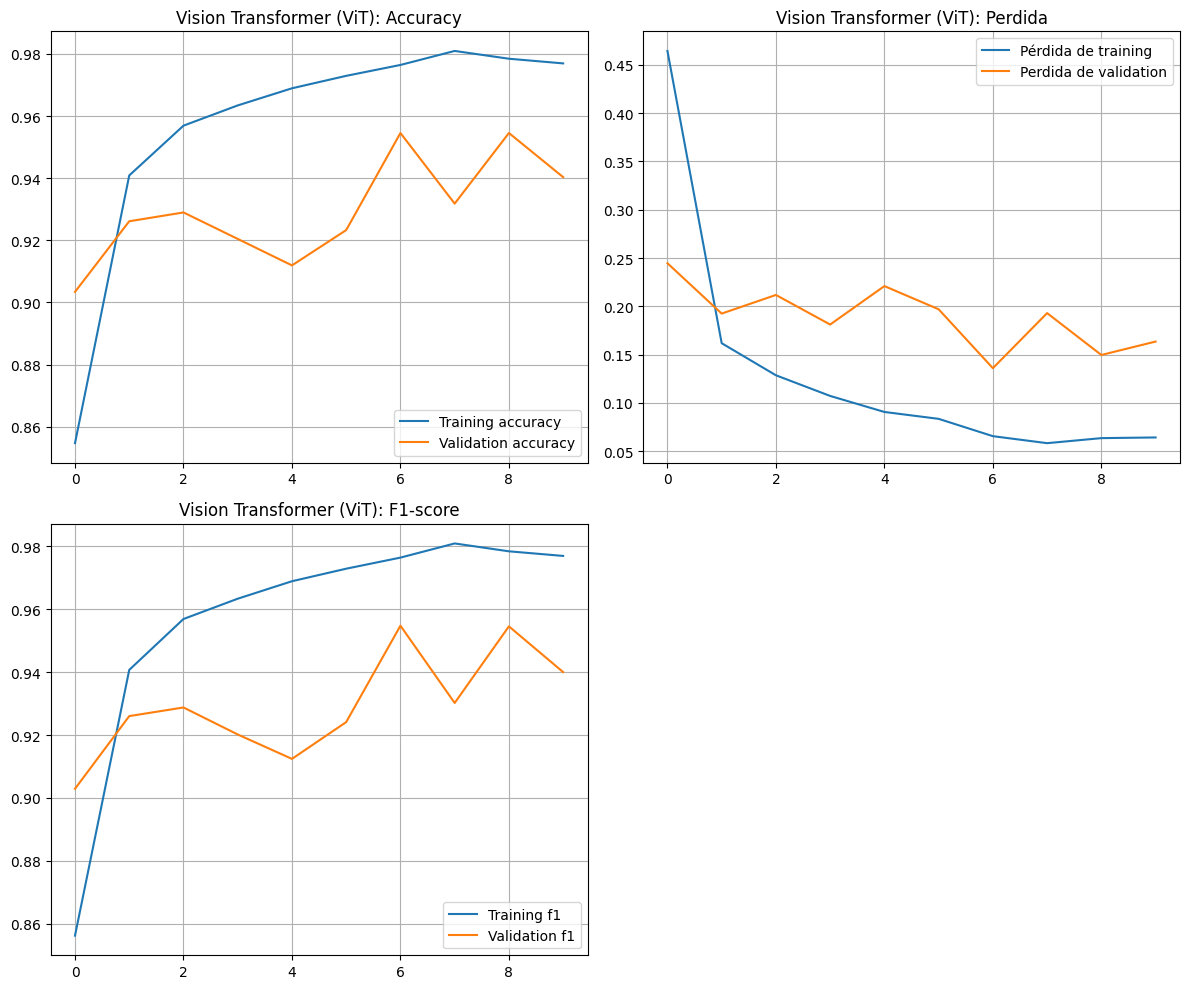


                         CNN vs ViT
Modelo                    | Parámetros   | Val Acc    | Val F1     | Tiempo(s) 
---------------------------------------------------------------------------
CNN (Propia)              | 26,086,090   | 0.9250  | 0.9247     | 50.6
ViT (HuggingFace)         | 86,588,682   | 0.9545  | 0.9548     | 412.7
---------------------------------------------------------------------------


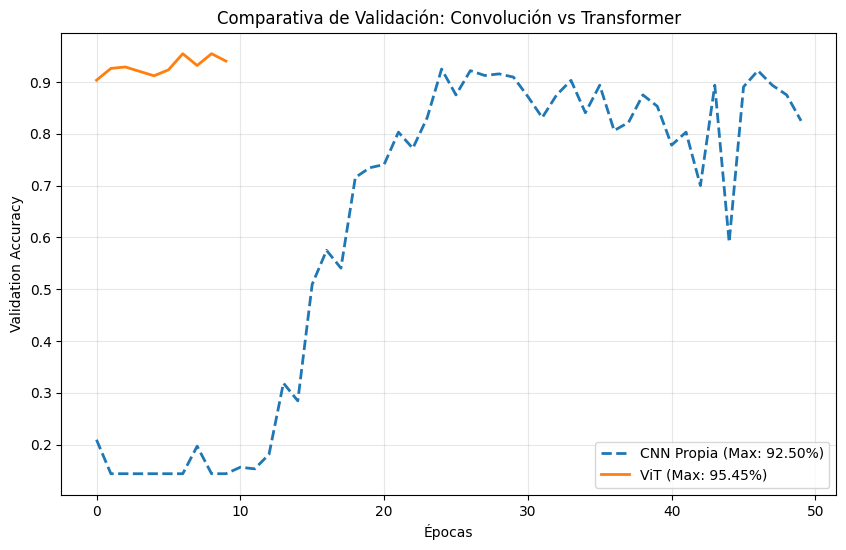

In [57]:
plot_history(history_vit, "Vision Transformer (ViT)")

# Recuperamos las métricas de la CNN asumiendo que siguen en memoria
cnn_best_val_acc = max(history_cnn.history['val_accuracy'])
cnn_best_val_f1 = max(history_cnn.history['val_f1_score'])
cnn_params = cnn_model.count_params()

# Recuperamos métricas del ViT
vit_best_val_acc = max(history_vit.history['val_accuracy'])
vit_best_val_f1 = max(history_vit.history['val_f1_score'])
vit_params = vit_model.count_params()

# tabla comparativa
print("\n" + "="*75)
print("                         CNN vs ViT")
print("="*75)
print(f"{'Modelo':<25} | {'Parámetros':<12} | {'Val Acc':<10} | {'Val F1':<10} | {'Tiempo(s)':<10}")
print("-" * 75)

# CNN
print(f"{'CNN (Propia)':<25} | {cnn_par:<12,} | {cnn_best_val_acc:.4f}  | {cnn_best_val_f1:.4f}     | {cnn_training_time:.1f}")

# ViT
print(f"{'ViT (HuggingFace)':<25} | {vit_params:<12,} | {vit_best_val_acc:.4f}  | {vit_best_val_f1:.4f}     | {vit_training_time:.1f}")
print("-" * 75)

# Grafica comparativa
plt.figure(figsize=(10, 6))

# Curva CNN
val_acc_cnn = history_cnn.history['val_accuracy']
plt.plot(val_acc_cnn, label=f'CNN Propia (Max: {cnn_best_val_acc:.2%})', linestyle='--', linewidth=2)

# Curva ViT
val_acc_vit = history_vit.history['val_accuracy']
plt.plot(val_acc_vit, label=f'ViT (Max: {vit_best_val_acc:.2%})', linewidth=2)

plt.title('Comparativa de Validación: Convolución vs Transformer')
plt.xlabel('Épocas')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


Vemos que con este dataset en específico la ViT no obtiene apenas ganancia, a pesar de tardar varias veces más que la CNN. Por otro lado, con el mismo número de épocas sí que obtiene bastante mejor resultado, por lo que es posible que si la dejaramos ejecutarse con el mismo número de épocas que la CNN aumentara la diferencia.

Este aumento de tiempo se entiende al mirar el número de parámetros, muy superior a la CNN y MLP. Es posible que con datasets mayores, con más resolución y complejidad el ViT obtuviese muchos mejores resultados.

---
## 7. Evaluación y Análisis Comparativo

En esta sección final evaluaremos el mejor modelo y realizaremos un estudio comparativo de todas las arquitecturas probadas.

**Tareas:**
1.  **Evaluación Cuantitativa:**
    * Carga el mejor modelo de todos los generados.
    * Genera el `classification_report` para ver la precisión, recall y F1-score por cada clase.
    * Visualiza la **Matriz de Confusión**. Identifica los pares de clases más problemáticos.

2.  **Análisis Cualitativo de Errores:**
    * Visualiza algunas imágenes mal clasificadas. 
    * **Requisito:** Muestra la imagen, la etiqueta real, la etiqueta predicha y el **nivel de confianza** (probabilidad) del modelo en esa predicción errónea. ¿Son errores "evitables"?

3.  **Comparativa Final:**
    * Crea un DataFrame de Pandas comparando al menos MLP, CNN Propia y CNN Transfer Learning (opcional ViT). *En este punto se pueden incluir también comparaciones con modelos con/sin aumento de datos, con/sin dropout, diversas arquitecturas...*
    * Ejemplo de columnas: `Modelo`, `Accuracy (Val)`, `F1-Score (Macro)`, `Nº Parámetros`, `Nº Parámetros Entrenables`, `Tiempo de Entrenamiento`.
    * **Conclusión:** Escribe un par de párrafos justificando cuál es la mejor arquitectura considerando el equilibrio entre recursos computacionales (parámetros/tiempo) y precisión.

Recopilando métricas...
Modelo cargado.
Clases válidas para evaluación (6): ['GOD_OF_WAR_1', 'HADES', 'HOLLOW_KNIGHT', 'MARIO_GALAXY', 'MINECRAFT', 'UNDERTALE']
Generando predicciones...

MATRIZ DE CONFUSIÓN


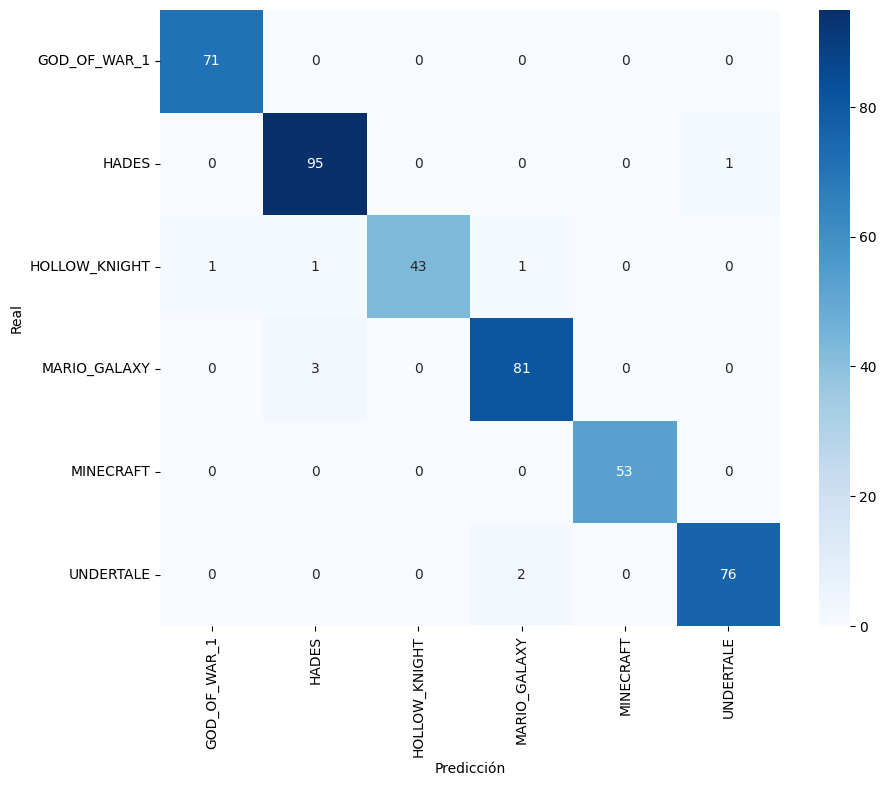


CLASSIFICATION REPORT
               precision    recall  f1-score   support

 GOD_OF_WAR_1       0.99      1.00      0.99        71
        HADES       0.96      0.99      0.97        96
HOLLOW_KNIGHT       1.00      0.93      0.97        46
 MARIO_GALAXY       0.96      0.96      0.96        84
    MINECRAFT       1.00      1.00      1.00        53
    UNDERTALE       0.99      0.97      0.98        78

     accuracy                           0.98       428
    macro avg       0.98      0.98      0.98       428
 weighted avg       0.98      0.98      0.98       428


Visualización de errores:


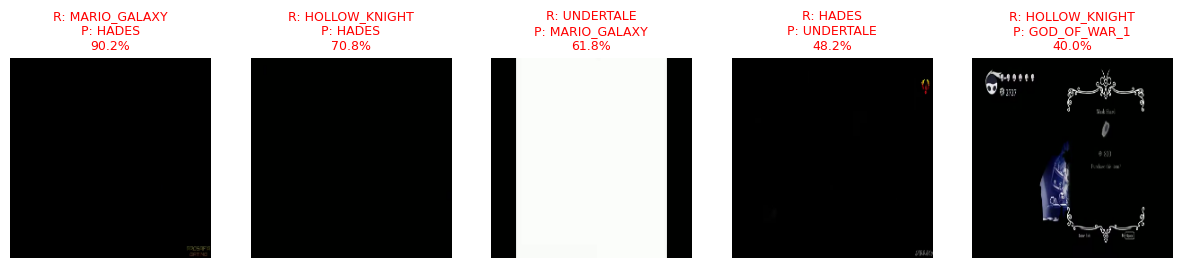

,Modelo,Accuracy (Val),F1-score (Val),Nº Parámetros,Tiempo (s)
2,Transfer Learning,0.984375,0.984378,5932122,411.507387
0,MLP Baseline,0.975000,0.975076,6457482,12.911451
3,Vision Transformer,0.954545,0.954796,86588682,412.743929
1,CNN Propia,0.925000,0.924683,26086090,50.565750


/tmp/ipykernel_55/428855826.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x='Modelo', y='Accuracy (Val)', palette='viridis')


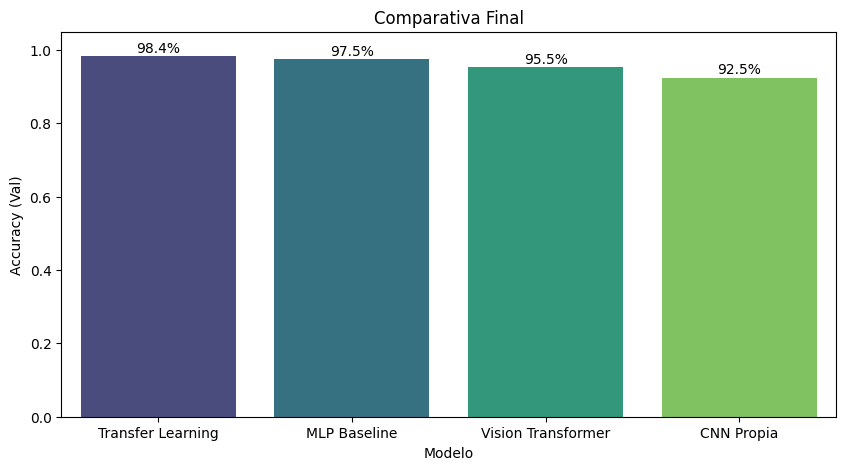

,Modelo,Accuracy (Val),F1-score (Val),Nº Parámetros,Tiempo (s)
2,Transfer Learning,0.984375,0.984378,5932122,411.507387
0,MLP Baseline,0.975000,0.975076,6457482,12.911451
3,Vision Transformer,0.954545,0.954796,86588682,412.743929
1,CNN Propia,0.925000,0.924683,26086090,50.565750


/tmp/ipykernel_55/428855826.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x='Modelo', y='F1-score (Val)', palette='viridis')


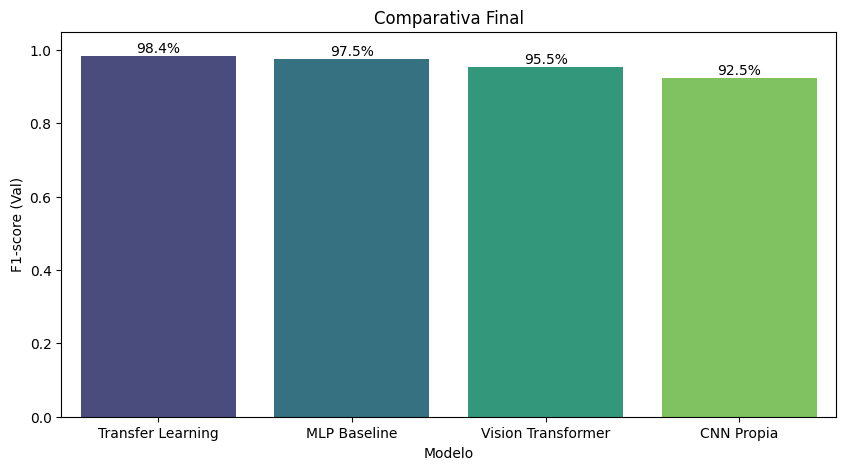

In [58]:
print("Recopilando métricas...")

best_model_path = 'best_transfer.keras' 
try:
    best_model = tf.keras.models.load_model(
        best_model_path,
        custom_objects={'SparseF1Score': SparseF1Score} 
    )
    print("Modelo cargado.")
except:
    print(f"Error cargando {best_model_path}.")
    best_model = None

metrics_data = []

def save_metric(model_var, history_var, name, time_var=0):
    if model_var in globals() and history_var in globals():
        try:
            model = globals()[model_var]
            history = globals()[history_var]
            val_acc = max(history.history['val_accuracy'])
            val_f1 = max(history.history['val_f1_score'])
            params = model.count_params()
            return {
                "Modelo": name,
                "Accuracy (Val)": val_acc,
                "F1-score (Val)": val_f1,
                "Nº Parámetros": params,
                "Tiempo (s)": globals().get(time_var, 0)
            }
        except:
            return None
    return None

metrics_data.append(save_metric('mlp_model', 'history_mlp', 'MLP Baseline', 'mlp_training_time'))
metrics_data.append(save_metric('cnn_model', 'history_cnn', 'CNN Propia', 'cnn_training_time'))
if 'history_finetune' in globals():
    metrics_data.append(save_metric('transfer_model', 'history_finetune', 'Transfer Learning', 'tl_training_time'))
elif 'history_tl' in globals():
    metrics_data.append(save_metric('transfer_model', 'history_tl', 'Transfer Learning (No FT)', 'tl_training_time'))
metrics_data.append(save_metric('vit_model', 'history_vit', 'Vision Transformer', 'vit_training_time'))

# Limpieza de RAM
heavy_vars = ['mlp_model', 'cnn_model', 'transfer_model', 'base_model', 'vit_model',
              'train_ds', 'val_ds', 'train_ds_vit', 'val_ds_vit', 'test_images', 'test_probs']
for var in heavy_vars:
    if var in globals(): del globals()[var]
tf.keras.backend.clear_session()
gc.collect()


# Filtramos 'allBands' si existe
real_class_names = [c for c in class_names if c != 'allBands']
print(f"Clases válidas para evaluación ({len(real_class_names)}): {real_class_names}")

if best_model:
    print("Generando predicciones...")
    y_true, y_pred, error_samples = [], [], []
    
    # Si test_ds fue borrado por el script anterior de limpieza, lo recargamos:
    if 'test_ds' not in globals():
        test_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir, validation_split=0.15, subset="validation", seed=2025,
            image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32, label_mode='int'
        )

    for batch_images, batch_labels in test_ds:
        preds = best_model.predict(batch_images, verbose=0)
        preds_ids = np.argmax(preds, axis=1)
        labels_ids = batch_labels.numpy().astype(int)
        
        valid_mask = labels_ids < 10 
        
        y_true.extend(labels_ids[valid_mask])
        y_pred.extend(preds_ids[valid_mask])
        
        if len(error_samples) < 5:
            batch_errors = np.where((preds_ids != labels_ids) & valid_mask)[0]
            for idx in batch_errors:
                if len(error_samples) >= 5: break
                error_samples.append({
                    'img': batch_images[idx].numpy().astype("uint8"),
                    'true': real_class_names[labels_ids[idx]],
                    'pred': real_class_names[preds_ids[idx]],
                    'conf': np.max(preds[idx])
                })
        del batch_images, batch_labels, preds
        gc.collect()

    print("\nMATRIZ DE CONFUSIÓN")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    # Usamos real_class_names que tiene el tamaño correcto
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=real_class_names, yticklabels=real_class_names)
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.show()
    
    print("\nCLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, target_names=real_class_names))
    
    if error_samples:
        print(f"\nVisualización de errores:")
        plt.figure(figsize=(15, 4))
        for i, sample in enumerate(error_samples):
            ax = plt.subplot(1, 5, i + 1)
            plt.imshow(sample['img'])
            plt.title(f"R: {sample['true']}\nP: {sample['pred']}\n{sample['conf']:.1%}", 
                      color='red', fontsize=9)
            plt.axis("off")
        plt.show()


df_results = pd.DataFrame([m for m in metrics_data if m is not None])
if not df_results.empty:
    df_results = df_results.sort_values(by="Accuracy (Val)", ascending=False)
    display(df_results)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_results, x='Modelo', y='Accuracy (Val)', palette='viridis')
    plt.title("Comparativa Final")
    plt.ylim(0, 1.05)
    for i, v in enumerate(df_results['Accuracy (Val)']):
        plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
    plt.show()

    df_results = df_results.sort_values(by="F1-score (Val)", ascending=False)
    display(df_results)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_results, x='Modelo', y='F1-score (Val)', palette='viridis')
    plt.title("Comparativa Final")
    plt.ylim(0, 1.05)
    for i, v in enumerate(df_results['F1-score (Val)']):
        plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
    plt.show()


### Análisis Cuantitativo
El modelo basado en Transfer Learning se posiciona como la mejor arquitectura. Se ve que supera ampliamente a las otras opciones tanto en accuracy como en F1-score, mostrando un equilibrio muy sólido entre precisión y exhaustividad. Esto confirma que partir de un modelo pre-entrenado permite obtener métricas de rendimiento muy altas, incluso con un conjunto de datos de entrenamiento relativamente pequeño, superando las limitaciones de aprender desde cero.

Con respecto a la matriz de confusion vemos una clara diagonal que nos indica que el modelo predice de forma correcta la mayoria de imagenes. Las mayores confusiones vienen por las parejas de Forest/SeaLake, River/Highway y HerbadeusVegetation/PermanentCrop. El primero de ellos puede deberse a la falta de resolucion de la imagen. En una imagen pequeña si solo cogiesemos el color de la misma, podriamos tener bosques mas azulados o lagos un poco mas verdosos. Cabe señalar que algunas de las imagenes mal clasificadas, son tan dificiles para el modelo como para nosotros, pues con una imagen tan pequeña es dificil obtener el contexto completo.



### Análisis Cualitativo
Al observar las imágenes mal clasificadas, notamos que los fallos no son aleatorios, sino que ocurren en situaciones de ambigüedad visual (como hemos indicado antes, por basar parte de la información en los colores, una recta de color medio gris/azul que puede ser asfalto o agua...). En muchas de estas predicciones erróneas, el modelo asigna un nivel de confianza más bajo que en sus aciertos, lo que sugiere que la red es consciente de la simulitud entre ambas clases.

### Comparativa final
El modelo MLP resultó ineficaz al perder la información espacial (aplanado de imagen), y nuestra CNN, aunque capaz de extraer características, se ha visto muy limitada. El Transfer Learning logró el equilibrio ideal: a pesar de tener una gran cantidad de parámetros totales, el uso de capas congeladas permitió un entrenamiento rápido y una capacidad de generalización muy superior. Por otro lado, el ViT consume muchos recursos pero no llega al nivel del Transfer Learning, por lo que no se justifica (al menos en este dataset) su uso. 

Es por eso que hemos elegido el Transfer Learning como mejor arquitectura, ya que ofrece la máxima precisión con un coste de entrenamiento razonable.

Como nota final, en lo que respecta a la forma de entrenamiento, hemos descubierto que la técnica Early Stopping es muy util si los datos que vamos a predecir cambian. Si el dataset al que tiene que enfrentarse el modelo no cambiase (como en una competición) esto permite un mayor overfitting pero se traduce tambien en mejores resultados (hasta cierto punto). Esto confirma lo que hemos ido viendo en clase a lo largo del cuatrimestre.